<a href="https://colab.research.google.com/github/christian-byrne/tucson-crime-models/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import all required imports and define some common types.

In [183]:
from typing import Union, Dict, Any, Tuple, Dict, List, Callable
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import requests
import random
import folium
from shapely.geometry import Point, Polygon, MultiPolygon
from pathlib import Path
from folium.plugins import HeatMap
from branca.colormap import LinearColormap
from branca.colormap import linear
import seaborn as sns
import pandas as pd
import sklearn.metrics
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from itertools import combinations
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.cm as cm
import matplotlib.colors
import warnings
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
)
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from rich.console import Console
from rich.panel import Panel
from rich.columns import Columns
from sklearn.metrics import roc_curve, RocCurveDisplay
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay


BoundingBox = Tuple[float, float, float, float]

# Suppress warnings
warnings.filterwarnings("ignore")

# Constants & Hyperparameters

This section defines the constants and hyperparameters used throughout the notebook. These configurations streamline the workflow by centralizing parameters such as dataset paths, model hyperparameters, and infrastructure feature definitions. Adjustments here allow for flexible experimentation and reproducibility without modifying individual code cells.


In [184]:
class Config:
    _config_data: Dict[str, Any] = {
        # hyperparameters
        "hp": {
            "test_size": 0.2,  # the ratio of the dataset to use for testing
            "subsection_count": 40,  # Number of subsections to divide the city into
            "subsection_count_model2": 22,  # Number of subsections to divide the city into
            "dataset_bounds_reference": "sidewalks",
            "dataset_bounds_reference_model2": "education",
            "cross_val_folds": {
                "linear": 5,
                "best_subset": 5,
                "lasso": 5,
                "ridge": 5,
                "svm": 3,
            },
            "scoring_metric": {  # the scoring metric to use for each model during cross-validation
                "best_subset": "r2",
                "lasso": "r2",
                "ridge": "r2",
                "svm": "accuracy",
            },
            "distance_to_nearest_infrastructure": [  # the sparse infrastructure types to calculate distance-to for
                "fire_stations",
                "landfills",
                "streetcar_stops",
                "streetcar_routes",
            ],
            "count_instances_infrastructure": [
                "bicycle_boulevards",
                "bridges",
                "crosswalks",
                "major_streets",
                "sidewalks",
                "streetlights",
                "suntran_stops",
            ],
            "geometry_contains_method": {  # the method to use to determine whether an infrastructure type is considered "nearby"
                "arrests": "within",
                "bicycle_boulevards": "intersects",
                "bridges": "within",
                "crosswalks": "intersects",
                "fire_stations": "within",
                "landfills": "within",
                "major_streets": "intersects",
                "streetcar_routes": "intersects",
                "streetcar_stops": "within",
                "scenic_routes": "intersects",
                "sidewalks": "intersects",
                "streetlights": "within",
                "suntran_stops": "within",
            },
        },
        "feature_names": {
            "model1": [
                "bicycle_boulevards",
                "bridges",
                "crosswalks",
                "fire_stations",
                "landfills",
                "major_streets",
                "streetcar_routes",
                "streetcar_stops",
                "scenic_routes",
                "sidewalks",
                "streetlights",
                "suntran_stops",
            ],
        },
        "tucson_center_coordinates": [32.22174, -110.92648],
        "tucson_bounds": [-111, 31.042601, -110.7347, 32.2226],
        "data_sources": {
            "arrests": "crime/Tucson_Police_Arrests_-_2017_-_Open_Data.geojson",
            "bicycle_boulevards": "infrastructure/Bicycle_Boulevards.geojson",
            "bridges": "infrastructure/Bridges_-_Open_Data.geojson",
            "business_licenses": "infrastructure/Business_Licenses_(Open_Data).geojson",
            "crosswalks": "infrastructure/Crosswalks_-_Open_Data.geojson",
            "education": "socio-economic/Neighborhood_Educational_Attainment.geojson",
            "fire_stations": "infrastructure/Fire_Stations.geojson",
            "income": "socio-economic/Neighborhood_Income.geojson",
            "landfills": "infrastructure/Landfills_(Eastern_Pima_County).geojson",
            "major_streets": "infrastructure/Major_Streets_and_Routes_-_Open_Data.geojson",
            "streetcar_routes": "infrastructure/Modern_Streetcar_Route_(Polygon)_-_Open_Data.geojson",
            "streetcar_stops": "infrastructure/Modern_Streetcar_Stops_-_Open_Data.geojson",
            "scenic_routes": "infrastructure/Scenic_Routes_-_Open_Data.geojson",
            "sidewalks": "infrastructure/Sidewalks.geojson",
            "streetlights": "infrastructure/Streetlights_-_City_of_Tucson_-_Open_Data.geojson",
            "suntran_stops": "infrastructure/Sun_Tran_Bus_Stops_-_Open_Data.geojson",
        },
    }

    def __getitem__(self, key: str) -> Any:
        """Get a configuration value by key, with KeyError if missing."""
        if key not in Config._config_data:
            msg = (
                f"Could not find key '{key}' in config."
                + f"Available keys: {list(Config._config_data.keys())}"
            )
            raise KeyError(msg)
        return Config._config_data[key]

    def __setitem__(self, key: str, value: Union[str, Path]) -> None:
        """Set a configuration value by key, converting Path to string if necessary."""
        if isinstance(value, Path):
            value = str(value.resolve())
        Config._config_data[key] = value


config = Config()

# Model 1: Predicting Crime Frequency from Infrastructure Features

## Data Collection

### Dataset Retrieval

This section loads geospatial datasets required for Model 1.

In [185]:
_cache: Dict[str, gpd.GeoDataFrame] = {}


def load_dataset(dataset_name: str) -> gpd.GeoDataFrame:
    """Load a geospatial dataset from the cache or repository."""
    if dataset_name in _cache:
        return _cache[dataset_name]  # Return cached dataset

    filepath = f"https://raw.githubusercontent.com/christian-byrne/tucson-crime-models/main/data/{config['data_sources'][dataset_name]}"

    if filepath.startswith("http"):
        response = requests.get(filepath)
        response.raise_for_status()
        with open(f"/tmp/{dataset_name}.geojson", "wb") as f:
            f.write(response.content)
        dataframe = gpd.read_file(f"/tmp/{dataset_name}.geojson")
    else:
        dataframe = gpd.read_file(filepath)

    _cache[dataset_name] = dataframe  # Cache for future use
    return dataframe

# Data Processing and Cleaning

## Define the Area of Interest

Given the variety of datasets used, there is significant variation in their geographic boundaries. To ensure consistency, a single dataset is used to define the area of interest for the analysis.

Initial testing with the `arrests` dataset as the reference was ineffective, as it excluded areas with no reported crimes, potentially limiting model generalizability. The `sidewalks` dataset was found to provide optimal bounds, tightly encompassing the city center and improving model performance.

In [186]:
# Set the reference dataset for area bounds
ref_dataset = config["hp"]["dataset_bounds_reference"] 

# Get the bounds of the reference dataset
min_x, min_y, max_x, max_y = load_dataset(ref_dataset).total_bounds 
print(
    "Setting the bounds of the area of interest based on the\n",
    f"{ref_dataset} dataset's bounds ({min_x, min_y, max_x, max_y})",
)

# Update the bounds in the config object
config["tucson_bounds"] = [min_x, min_y, max_x, max_y] 

Setting the bounds of the area of interest based on the
 sidewalks dataset's bounds ((np.float64(-111.05254574930352), np.float64(32.06233602492571), np.float64(-110.72263755643428), np.float64(32.32006865632446)))


## Partition Area of Interest into Subsections

To create rows for both models, the area of interest is partitioned into smaller subsections. These subsections represent the items for the dataset, enabling the model to analyze localized infrastructure and crime data effectively.

### Sampling Methodology

Initially, the area was divided into equally sized grid subsections. However, introducing randomness to the sampling process—both in the location and size of subsections—significantly improved model performance. This semi-random sampling approach increased the $R^2$ score from approximately 0.7 to 0.96, likely due to better generalization and reduced overfitting.

In [187]:
def gen_ran_subsection_sample(
    bounds_box: BoundingBox, target_num: int, load_from_file: bool = False
) -> List[BoundingBox]:
    """
    Generate semi-random subsections for a given geographic area.

    Args:
        bounds_box (BoundingBox): Tuple (min_x, min_y, max_x, max_y) defining the bounding box.
        target_num (int): Desired number of subsections (approximate).
        load_from_file (bool): Whether to load a pre-computed sample from a file.

    Returns:
        List[BoundingBox]: List of bounding boxes representing the subsections.
    """
    if load_from_file:
        # Load pre-computed optimal subsections
        subsections = pd.read_csv(
            "https://raw.githubusercontent.com/christian-byrne/tucson-crime-models/main/good-subsection-splits.csv"
        )
        return [
            (row["min_x"], row["min_y"], row["max_x"], row["max_y"])
            for _, row in subsections.iterrows()
        ]

    min_x, min_y, max_x, max_y = bounds_box
    total_width = max_x - min_x
    total_height = max_y - min_y
    approx_size = (total_width * total_height) / target_num
    approx_width = approx_size**0.5
    approx_height = approx_size**0.5

    subsections = []
    current_y = min_y

    while total_height > 0:
        # Adjust row height with a random factor
        row_height = min(
            random.uniform(0.8 * approx_height, 1.2 * approx_height), total_height
        )
        total_height -= row_height
        current_x = min_x
        remaining_width = total_width

        while remaining_width > 0:
            # Adjust column width with a random factor
            col_width = min(
                random.uniform(0.8 * approx_width, 1.2 * approx_width), remaining_width
            )
            remaining_width -= col_width

            # Append subsection bounds
            subsections.append(
                (current_x, current_y, current_x + col_width, current_y + row_height)
            )
            current_x += col_width

        current_y += row_height

    return subsections

### Subsection Sampling Methodology

The sampling method is "semi-random," allowing flexibility in subsection creation while aiming to stay close to a specified target number. This ensures a balance between structure and randomness, helping the model generalize better.

#### Subsection Count Hyperparameter

K-fold cross-validation identified the optimal number of subsections to be between 16 and 25. Increasing beyond 25 often led to overfitting due to highly variable feature values in smaller subsections, while decreasing below 16 caused underfitting by failing to capture sufficient data patterns.

In [188]:
# Partition the area into subsections based on the configured target count
print(f"Partitioning Tucson into {config['hp']['subsection_count']} subsections")
subsections = gen_ran_subsection_sample(
    config["tucson_bounds"], config["hp"]["subsection_count"], load_from_file=True
)

Partitioning Tucson into 40 subsections


## Exploratory Data Analysis and Visualization

### Visualizing Subsection Samples on a Map

To ensure the subsections align with the area of interest and are well-distributed, we visualize their boundaries on a geographic map. This step helps:

- Confirm that the subsections span the target area.
- Detect potential issues, such as overlapping or overly sparse subsections.
- Validate the randomness in subsection sizes and locations, ensuring adequate noise for generalization.

In [189]:
def visualize_subsections_on_map(
    subsections: List[BoundingBox],
    center_coordinates: Tuple[float, float],
    zoom_start: int = 11,
    fill_opacity: float = 0.16,
    color: str = "blue",
) -> folium.Map:
    """
    Visualize geographical subsections on a Folium map.

    Args:
        subsections (List[BoundingBox]): Bounding boxes for subsections in (min_x, min_y, max_x, max_y) format.
        center_coordinates (Tuple[float, float]): Latitude and longitude to center the map.
        zoom_start (int): Initial zoom level for the map.
        fill_opacity (float): Transparency level for subsection fills.
        color (str): Outline color for subsections.

    Returns:
        folium.Map: Map object displaying the subsections.
    """
    # Create a Folium map centered at the given location
    folium_map = folium.Map(location=center_coordinates, zoom_start=zoom_start)

    # Add rectangles for each subsection
    for subsection in subsections:
        bounds = [[subsection[1], subsection[0]], [subsection[3], subsection[2]]]
        folium.Rectangle(
            bounds, color=color, fill=True, fill_opacity=fill_opacity
        ).add_to(folium_map)

    return folium_map


visualize_subsections_on_map(subsections, config["tucson_center_coordinates"])

### Exploring Infrastructure Datasets

To predict crime frequency using infrastructure features, we analyze spatial distributions and relationships in the data. Multiple infrastructure datasets are visualized on a geographic map to:

- Examine the spatial density and patterns of features like sidewalks, crosswalks, and streetlights.
- Identify potential correlations between infrastructure features and crime frequency.
- Ensure that features are appropriately distributed across the area of interest for robust modeling.

Heatmaps are used to visualize point-based and line-based features, providing a clearer understanding of their density and overlap. This includes layering the target variable `Arrests` to analyze its initial relationship with infrastructure features.

In [190]:
def visualize_feature_heatmaps(
    datasets: dict[str, gpd.GeoDataFrame],
    subsections: list[tuple[float, float, float, float]],
    zoom_start=12,
    fill_opacity=0.2,
    heatmap_radius=10,
):
    """
    Visualizes multiple heatmaps for different datasets on the same map with toggle buttons.

    Params:
    datasets: dict[str, GeoDataFrame] - Dictionary where keys are category names and values are GeoDataFrames for each category.
    subsections: list[tuple[float]] - List of bounding boxes for subsections in (min_x, min_y, max_x, max_y) format.
    zoom_start: int - Initial zoom level of the map.
    fill_opacity: float - Opacity of the subsection rectangles.
    heatmap_radius: int - Radius of the heatmap points.

    Returns:
    folium.Map: The Folium map with multiple heatmaps and toggle buttons.
    """
    # Create a Folium map centered on Tucson
    folium_map = folium.Map(
        location=config["tucson_center_coordinates"],
        zoom_start=zoom_start,
    )

    # Add rectangles for each subsection
    for subsection in subsections:
        bounds = [[subsection[1], subsection[0]], [subsection[3], subsection[2]]]
        folium.Rectangle(
            bounds, color="blue", fill=True, fill_opacity=fill_opacity
        ).add_to(folium_map)

    # Create a colormap for categories
    colormap = LinearColormap(
        colors=[
            "red",
            "green",
            "blue",
            "purple",
        ],
        index=range(len(datasets)),
        vmin=0,
        vmax=max(1, len(datasets) - 1)  # Ensure vmax is at least 1 
    )

    # Add heatmaps and category groups
    for i, (category, data) in enumerate(datasets.items()):
        data = data[data.geometry.notnull()]  # Filter out missing or non-Point geometry
        category_group = folium.FeatureGroup(
            name=f"{category} Heatmap",
            show=category == "arrests" or category == "bicycle_boulevards",
        )
        heatmap_data = []

        # Extract heatmap data from GeoDataFrame
        for _, obj in data.iterrows():
            if obj.geometry.geom_type == "Point":
                heatmap_data.append([obj.geometry.y, obj.geometry.x])
            elif obj.geometry.geom_type == "LineString":
                heatmap_data.extend(
                    [[point[1], point[0]] for point in obj.geometry.coords]
                )

        # Add heatmap with specific color
        if heatmap_data:
            color = colormap.rgb_hex_str(i / (len(datasets) - 1))  # Use hex color
            HeatMap(
                heatmap_data,
                radius=heatmap_radius,
                gradient={0: color},  # Gradient for the category
                blur=15,
            ).add_to(category_group)
        category_group.add_to(folium_map)  # Add the category group to the map

    # Add LayerControl and ensure it stays expanded
    layer_control = folium.LayerControl().add_to(folium_map)

    # Add the legend to the map
    legend_html = """
    <div style="
        position: fixed;
        bottom: 50px;
        left: 50px;
        width: 150px;
        height: auto;
        padding: 10px;
        background-color: white;
        z-index: 9999;
        font-size: 14px;
        border: 1px solid black;
        border-radius: 5px;
    ">
    <b>Legend</b> - Use the layer button on the top right of the map to toggle feature heatmap layers<br>
    """
    for i, category in enumerate(datasets.keys()):
        color = colormap.rgb_hex_str(i / (len(datasets) - 1))
        legend_html += f"""
        <i style="background: {color}; width: 10px; height: 10px; display: inline-block;"></i>
        {category}<br>
        """
    legend_html += "</div>"
    folium_map.get_root().html.add_child(folium.Element(legend_html))

    return folium_map


# Load each infrastructure dataset and arrests dataset and map them to a name
infra_data = {
    dataset_name: load_dataset(dataset_name)
    for dataset_name in config["feature_names"]["model1"] + ["arrests"]
}
visualize_feature_heatmaps(infra_data, subsections)

AttributeError: 'int' object has no attribute 'split'

### Addressing Key Observations

From the visualizations, two key issues have been identified:

1. **Sparse Features**: Certain infrastructure features, such as fire stations or landfills, are too sparse to be effectively represented as densities.
2. **Strong Inter-Feature Correlations**: Some feature pairs exhibit high correlations, suggesting they measure overlapping or identical phenomena, which could impact model interpretability.

#### Transforming Sparse Features: Incidence Count to Distance to Nearest

To address the sparsity issue, we transform these features from simple counts into the distance to the nearest instance of the feature. This approach captures spatial information without implying a linear relationship between feature density and its impact on crime.

Below, we list the features identified as sparse and requiring this transformation:


In [191]:
# Identify sparse features for transformation
sparse_features = config["hp"]["distance_to_nearest_infrastructure"]
print(
    "Identified the following features as having sparse data and requiring transformation to distance metrics:\n",
    sparse_features,
)

Identified the following features as having sparse data and requiring transformation to distance metrics:
 ['fire_stations', 'landfills', 'streetcar_stops', 'streetcar_routes']


### Processing Infrastructure Features

#### Process Density Features

For features with sufficient spatial density, we use their nominal incidence count as the feature value. This involves extracting feature values from datasets and assigning them to subsections based on specific spatial relationships.

#### Methodology for Feature Value Extraction

To determine whether a feature instance is "inside" a subsection, we evaluated several spatial relationship methods:

- **`within`**: The feature instance is entirely contained within the subsection.
- **`intersects`**: The feature instance overlaps any part of the subsection.
- **`contains`**: The subsection and feature instance overlap but exclude cases where one entirely contains the other.

While tuning these as hyperparameters was considered, a heuristic approach ultimately yielded better results. Each feature is assigned a spatial relationship based on its practical definition. The exact method used for each feature is listed below:

In [192]:
# Report the geometry method for each infrastructure type
for feature_, geo_method in config["hp"]["geometry_contains_method"].items():
    print(f"{feature_:<20} {geo_method}") 

arrests              within
bicycle_boulevards   intersects
bridges              within
crosswalks           intersects
fire_stations        within
landfills            within
major_streets        intersects
streetcar_routes     intersects
streetcar_stops      within
scenic_routes        intersects
sidewalks            intersects
streetlights         within
suntran_stops        within


In [193]:
def count_objects_in_subsection(
    objects: gpd.GeoDataFrame,
    subsection: Union[tuple[float, float, float, float], Polygon, MultiPolygon],
    object_name: str,
    use_polygon: bool = False,
    condition: Callable[[gpd.GeoSeries], bool] = None,
) -> int:
    """
    Count objects (sidewalk, landfill, crosswalk, etc.) within a given subsection or neighborhood,
    optionally filtering objects based on a condition.

    Params:
    objects: GeoDataFrame - Locations of objects.
    subsection: Union[BoundingBox, Polygon, MultiPolygon] - Bounding box (min_x, min_y, max_x, max_y)
                or geometry of the subsection/neighborhood.
    object_name: str - Name of the object type, used for determining the geometry matching method.
    use_polygon: bool - Whether to treat the subsection as a Polygon/MultiPolygon. Defaults to False.
    condition: Callable[[gpd.GeoSeries], bool] - Optional function to filter objects based on a condition.

    Returns:
      int - Number of objects in the subsection meeting the condition (if provided).
    """
    # If using a bounding box, create the subsection as a box
    if not use_polygon and isinstance(subsection, tuple):
        # subsection_geom = box(*subsection)
        subsection_geom = Polygon(
            [
                [subsection[0], subsection[1]],
                [subsection[2], subsection[1]],
                [subsection[2], subsection[3]],
                [subsection[0], subsection[3]],
            ]
        )
    elif use_polygon and isinstance(subsection, (Polygon, MultiPolygon)):
        subsection_geom = subsection
    else:
        raise ValueError(
            "Invalid subsection type. Provide a bounding box (tuple) or a Polygon/MultiPolygon."
        )

    # Determine the method to use for spatial filtering
    method = config["hp"]["geometry_contains_method"][object_name]

    # Filter objects based on spatial relationship
    if method == "within":
        objects_in_subsection = objects[objects.geometry.within(subsection_geom)]
    elif method == "intersects":
        objects_in_subsection = objects[objects.geometry.intersects(subsection_geom)]
    elif method == "overlaps":
        objects_in_subsection = objects[objects.geometry.overlaps(subsection_geom)]
    else:
        raise ValueError(f"Invalid geometry method: {method}")

    # Apply the condition if provided
    if condition:
        objects_in_subsection = objects_in_subsection[
            objects_in_subsection.apply(condition, axis=1)
        ]

    return len(objects_in_subsection)

#### Process Distance Features

For sparse features, the distance to the nearest feature instance is used as the feature value. This approach captures spatial relevance without implying a direct density relationship.

The function below calculates the distance from the center of a subsection to the nearest feature. If a feature instance lies within the subsection, the distance is set to zero, ensuring accurate representation of proximity.

In [194]:
def distance_to_nearest(objects: gpd.GeoDataFrame, subsection: BoundingBox):
    # Create a point at the center of the subsection
    center_x = (subsection[0] + subsection[2]) / 2
    center_y = (subsection[1] + subsection[3]) / 2
    center_point = gpd.GeoSeries([Point(center_x, center_y)], crs="EPSG:4326")

    # Reproject to a projected CRS for distance calculations (e.g., UTM or a global CRS like EPSG:3857)
    projected_crs = "EPSG:3857"
    objects_projected = objects.to_crs(projected_crs)
    center_point_projected = center_point.to_crs(projected_crs)

    # If one of the objects is INSIDE of the subsection, the distance will be 0, do this separately
    if objects_projected.within(center_point_projected.iloc[0]).any():
        return 0.0

    # Calculate the distance to the nearest object
    return objects_projected.distance(center_point_projected.iloc[0]).min()

### Create the Input Features

To prepare the dataset for modeling, we aggregate the processed features into a single DataFrame. 

#### Distance Features

For sparse features, we calculate the distance to the nearest instance for each subsection and store these as columns in the DataFrame. This ensures that each feature captures relevant spatial relationships across the area of interest.

In [195]:
col_names = []
cols = []
for feature in config["hp"]["distance_to_nearest_infrastructure"]:
    feature_col = []
    dataset = load_dataset(feature)
    for subsection in subsections:
        feature_col.append(distance_to_nearest(dataset, subsection))

    cols.append(feature_col)
    col_names.append(f"distance_to_nearest_{feature}")

df = pd.DataFrame(cols).T  # Create a DataFrame
df.columns = col_names
df.head()  # Preview the DataFrame

distance_to_nearest_fire_stations  distance_to_nearest_landfills  \
0                        3570.684876                    8181.369052   
1                        3567.317034                    3671.235203   
2                         901.712818                     718.522916   
3                        4208.127744                    3871.341136   
4                        2906.090212                    3294.865540   

   distance_to_nearest_streetcar_stops  distance_to_nearest_streetcar_routes  
0                         18084.590003                          18065.251999  
1                         17271.049392                          17262.114571  
2                         17569.097586                          17522.332029  
3                         18875.510098                          18822.484825  
4                         20722.911756                          20662.432774

#### Density Features

In [196]:
for feature in config["hp"]["count_instances_infrastructure"]:
    dataset = load_dataset(feature)
    df[f"count_{feature}"] = [
        count_objects_in_subsection(dataset, subsection, feature)
        for subsection in subsections
    ]

df.head()  # Preview the DataFrame

distance_to_nearest_fire_stations  distance_to_nearest_landfills  \
0                        3570.684876                    8181.369052   
1                        3567.317034                    3671.235203   
2                         901.712818                     718.522916   
3                        4208.127744                    3871.341136   
4                        2906.090212                    3294.865540   

   distance_to_nearest_streetcar_stops  distance_to_nearest_streetcar_routes  \
0                         18084.590003                          18065.251999   
1                         17271.049392                          17262.114571   
2                         17569.097586                          17522.332029   
3                         18875.510098                          18822.484825   
4                         20722.911756                          20662.432774   

   count_bicycle_boulevards  count_bridges  count_crosswalks  \
0                         0              0                 0   
1                         0              0                 0   
2                         0              0                 0   
3                         0              0                 0   
4                         0              0                 0   

   count_major_streets  count_sidewalks  count_streetlights  \
0                    0                0                   0   
1                    2                0                   0   
2                    6                0                   0   
3                   11                0                   0   
4                   18                0                   0   

   count_suntran_stops  
0                    2  
1                    4  
2                    6  
3                    0  
4                    0

#### Visualize Feature Sparsity After Transformation

To evaluate whether the sparse features have been appropriately handled, we visualize the proportion of non-zero values for each feature. This analysis verifies that features are not overly sparse and can contribute meaningful information to the model.

Additionally, this step helps identify any features with potential multicollinearity, which will be addressed in subsequent steps.


In [197]:
def visualize_feature_nonzero_proportion(dataframe: pd.DataFrame):
    """
    Create a bar plot showing the proportion of non-zero values for each feature.

    Params:
    dataframe: pd.DataFrame - Input DataFrame to analyze.

    Returns:
    None
    """
    nonzero_proportion = (dataframe != 0).sum(axis=0) / len(dataframe)
    plt.figure(figsize=(12, 6))
    nonzero_proportion.sort_values().plot(kind="bar", color="skyblue")
    plt.title("Proportion of Non-Zero Values Across Features")
    plt.ylabel("Proportion")
    plt.xlabel("Features")
    plt.xticks(rotation=45)
    plt.tight_layout()

Plot the sparsity of each feature side-by-side:

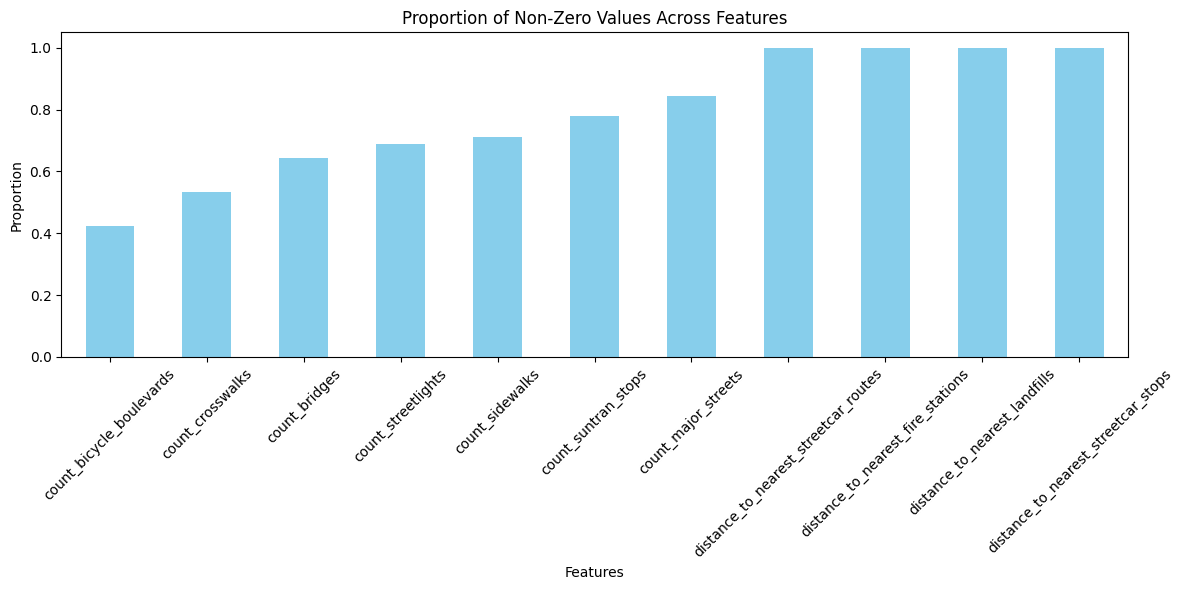

In [198]:
visualize_feature_nonzero_proportion(df)

#### Visualize Feature Distributions

To ensure that each feature is appropriately processed and transformed, we analyze their distributions. This step helps identify whether additional transformations, scaling, or re-engineering are required for optimal modeling performance.

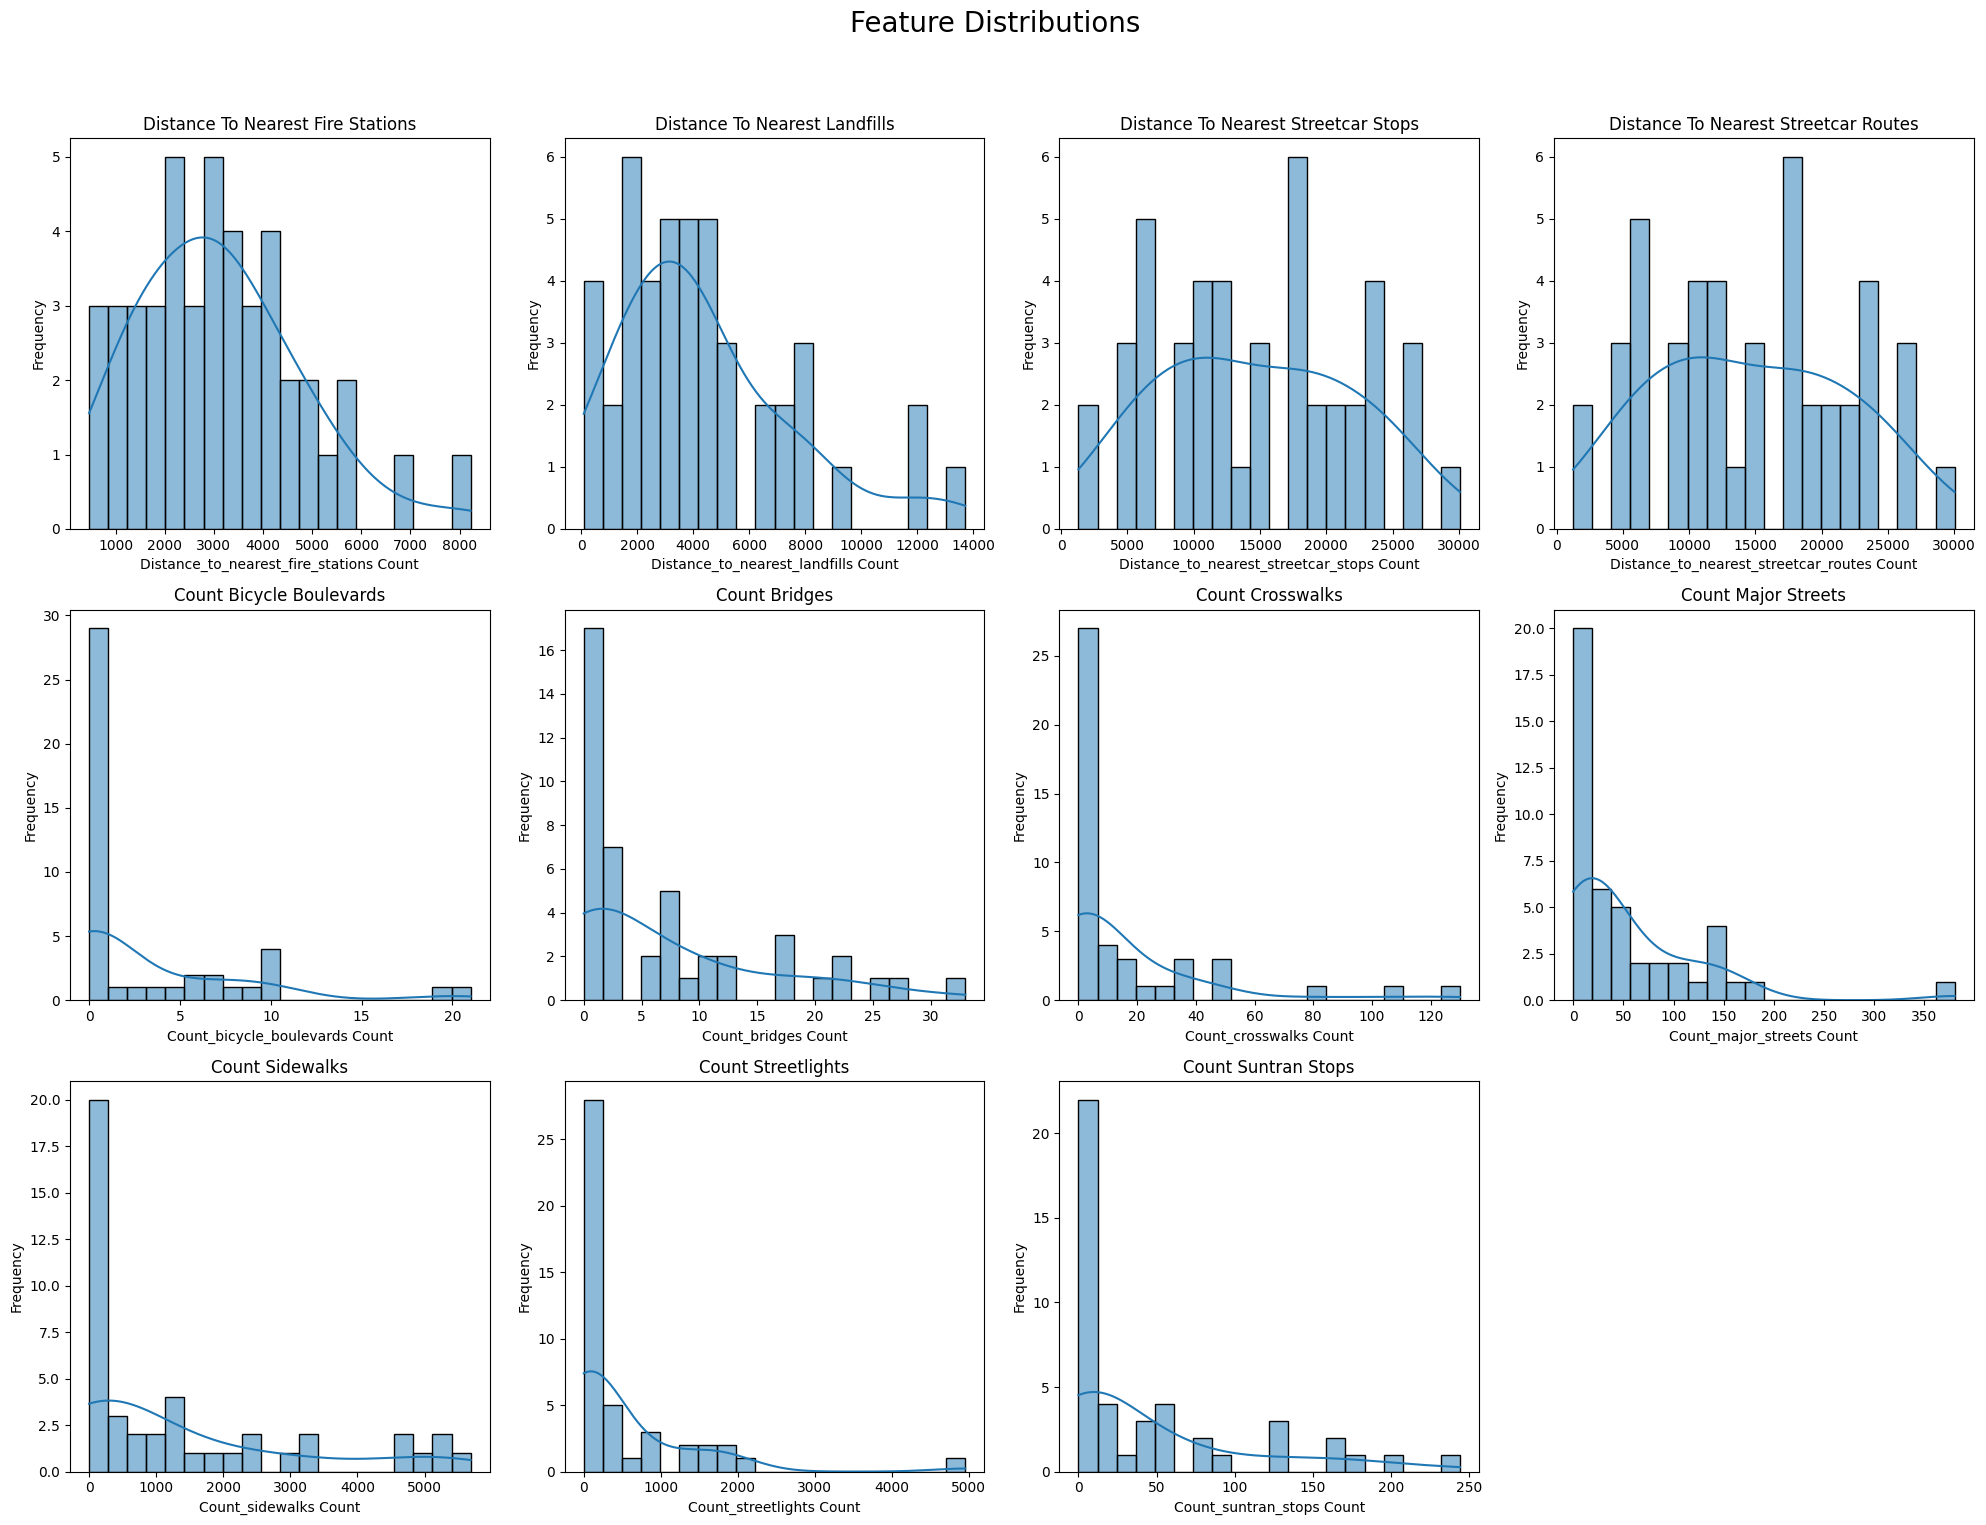

In [199]:
def visualize_feature_densities(dataframe: pd.DataFrame):
    """Create a single plot with subplots for each feature in the input DataFrame.
    Show the distribution of each feature in order to determine if transformations, projections, or re-engineering are needed.
    """
    # Create a figure with a subplot for each feature
    fig, axs = plt.subplots(len(dataframe.columns) // 4 + 1, 4, figsize=(20, 16))
    fig.suptitle("Feature Distributions", fontsize=20)

    # Iterate over each feature and create a histogram
    for i, feature in enumerate(dataframe.columns):
        sns.histplot(dataframe[feature], kde=True, bins=20, ax=axs[i // 4, i % 4])
        axs[i // 4, i % 4].set_xlabel(f"{feature.capitalize()} Count")

        # Only need to label y if it's the first column
        axs[i // 4, i % 4].set_ylabel("Frequency")
        axs[i // 4, i % 4].set_title(f"{feature.replace('_', ' ').title()}")

    # Hide any unused subplots
    for i in range(len(dataframe.columns), len(axs.flat)):
        axs.flat[i].set_visible(False)

    # Adjust layout and display the plot
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


visualize_feature_densities(df)

### Identify Multicollinearity within Input Features

To address concern (2), we examine multicollinearity between features by constructing a correlation matrix and visualizing it using a heatmap.

**Why Address Multicollinearity?**

- Highly correlated features (multicollinearity) can make coefficient estimates unreliable, as some features might inadvertently represent contributions from other correlated features.
- Removing or consolidating correlated features reduces redundancy, simplifies the model, and enhances interpretability without compromising performance.

**Key Considerations:**

- Correlation measures only linear relationships. Non-linear dependencies may still exist and require alternative analyses (e.g., mutual information).
- Correlated features may still hold independent predictive value in non-linear models like gradient boosting. Therefore, decisions about feature removal or consolidation should be made carefully.

We use the Pearson method to measure linear correlations among features. This approach identifies features that may need transformation or consolidation into a single, more informative feature.

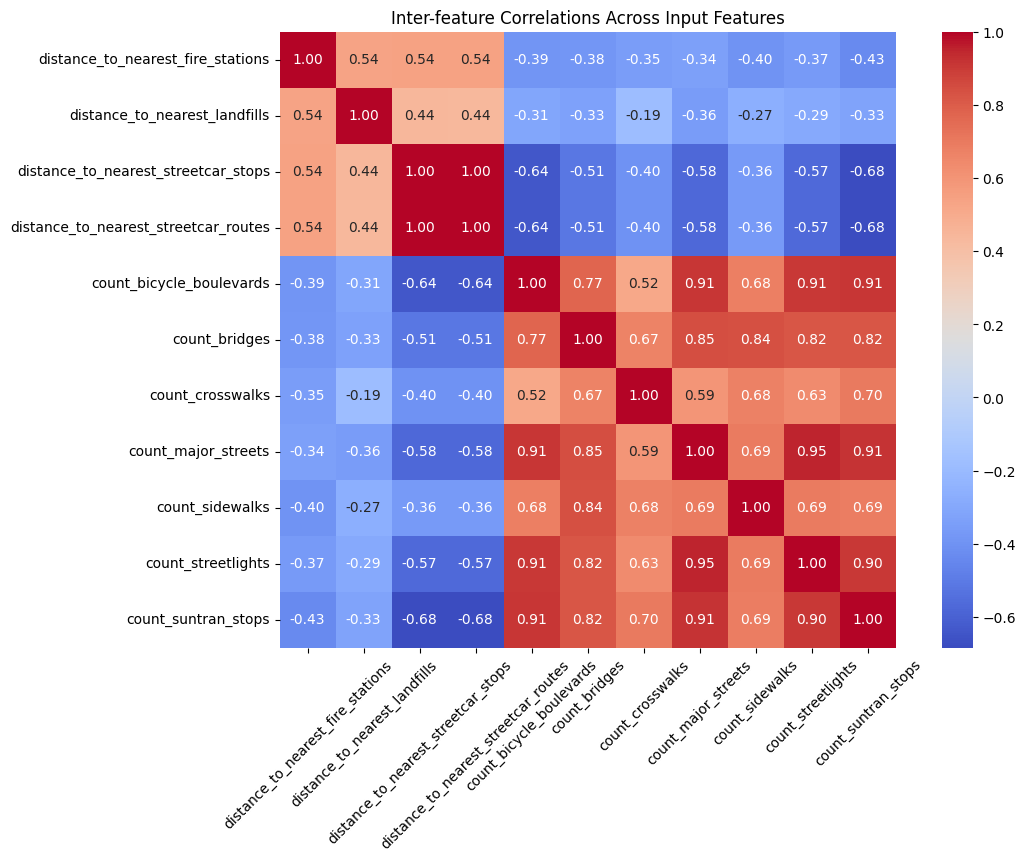

In [200]:
def correlation_heatmap(dataframe: pd.DataFrame):
    """
    Generate a heatmap of correlation coefficients for all numerical features in the DataFrame.
    """
    corr_matrix = dataframe.corr(method="pearson")  # Compute correlation matrix
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True
    )
    plt.xticks(rotation=45)  # Rotate the x-tick labels for better readability
    plt.title("Inter-feature Correlations Across Input Features")
    plt.show()


correlation_heatmap(df)

We will set a threshold for correlation strength and report any pairs of features that exceed this threshold.

In [201]:
MULTICOLLINEARITY_THRESHOLD = 0.93
correlation_matrix = df.corr()  # Compute the correlation matrix

# Find pairs with correlation above the threshold
high_correlation = (correlation_matrix > MULTICOLLINEARITY_THRESHOLD) & (
    correlation_matrix < 1
)

# Stack the correlation matrix and filter based on the high_correlation mask
high_correlation_pairs = (
    correlation_matrix.where(
        high_correlation
    )  # Mask correlations not above the threshold
    .stack()  # Convert to Series for filtering
    .reset_index()  # Convert to DataFrame for better readability
)
high_correlation_pairs.columns = [
    "Feature 1",
    "Feature 2",
    "Correlation",
]  # Rename columns for clarity
high_correlation_pairs  # Display the pairs of features with high correlation

Feature 1                             Feature 2  \
0   distance_to_nearest_streetcar_stops  distance_to_nearest_streetcar_routes   
1  distance_to_nearest_streetcar_routes   distance_to_nearest_streetcar_stops   
2                   count_major_streets                    count_streetlights   
3                    count_streetlights                   count_major_streets   

   Correlation  
0     0.999993  
1     0.999993  
2     0.950527  
3     0.950527

#### Combine/Drop Collinear Features

The correlation heatmap revealed several pairs of highly correlated features, necessitating feature reduction to mitigate multicollinearity. This can be achieved by either dropping redundant features or combining them into a single composite feature.

**Approach Taken:**
1. Features that were deemed less informative during initial testing (e.g., `business_licenses`, `scenic_routes`) were dropped.
2. For remaining highly-correlated pairs, Principal Component Analysis (PCA) was employed to combine features with similar scales. This approach preserves the variance explained by the original features while reducing redundancy. It also ensures that the new feature is less prone to overfitting and better suited for the training data.

The PCA-combined features distribute the variance more evenly and help simplify the feature space while maintaining predictive power.

In [202]:
# Keep track of features that have already been processed
processed_features = set()

# Iterate through high correlation pairs
for _, row in high_correlation_pairs.iterrows():
    feature_1, feature_2 = row["Feature 1"], row["Feature 2"]

    # Skip if either feature has already been processed
    if feature_1 in processed_features or feature_2 in processed_features:
        continue

    # Perform PCA on the pair of features
    pca = PCA(n_components=1)
    new_feature_name = f"{feature_1}_and_{feature_2}_PCA"
    df[new_feature_name] = pca.fit_transform(df[[feature_1, feature_2]])

    # Drop the original features
    df.drop([feature_1, feature_2], axis=1, inplace=True)

    # Mark these features as processed
    processed_features.update([feature_1, feature_2])

df.head()

distance_to_nearest_fire_stations  distance_to_nearest_landfills  \
0                        3570.684876                    8181.369052   
1                        3567.317034                    3671.235203   
2                         901.712818                     718.522916   
3                        4208.127744                    3871.341136   
4                        2906.090212                    3294.865540   

   count_bicycle_boulevards  count_bridges  count_crosswalks  count_sidewalks  \
0                         0              0                 0                0   
1                         0              0                 0                0   
2                         0              0                 0                0   
3                         0              0                 0                0   
4                         0              0                 0                0   

   count_suntran_stops  \
0                    2   
1                    4   
2                    6   
3                    0   
4                    0   

   distance_to_nearest_streetcar_stops_and_distance_to_nearest_streetcar_routes_PCA  \
0                                        4867.399364                                  
1                                        3724.230406                                  
2                                        4119.002802                                  
3                                        5962.125494                                  
4                                        8569.478500                                  

   count_major_streets_and_count_streetlights_PCA  
0                                     -508.595178  
1                                     -508.448187  
2                                     -508.154205  
3                                     -507.786728  
4                                     -507.272259

### Create Target Feature

The target variable for the first model is the crime frequency, represented by the number of arrests in each subsection.

To calculate this:

1. The `arrests` dataset is loaded.
2. Arrests are counted for each subsection using the same methodology as input density features, ensuring consistency in feature engineering.

This approach ensures that the target variable aligns well with the input features, facilitating accurate model training and evaluation.

In [203]:
# Add the target variable: crime frequency (number of arrests) per subsection
df["arrests"] = [
    count_objects_in_subsection(load_dataset("arrests"), subsection, "arrests")
    for subsection in subsections
]

# Display a preview of the updated DataFrame
df.head()

distance_to_nearest_fire_stations  distance_to_nearest_landfills  \
0                        3570.684876                    8181.369052   
1                        3567.317034                    3671.235203   
2                         901.712818                     718.522916   
3                        4208.127744                    3871.341136   
4                        2906.090212                    3294.865540   

   count_bicycle_boulevards  count_bridges  count_crosswalks  count_sidewalks  \
0                         0              0                 0                0   
1                         0              0                 0                0   
2                         0              0                 0                0   
3                         0              0                 0                0   
4                         0              0                 0                0   

   count_suntran_stops  \
0                    2   
1                    4   
2                    6   
3                    0   
4                    0   

   distance_to_nearest_streetcar_stops_and_distance_to_nearest_streetcar_routes_PCA  \
0                                        4867.399364                                  
1                                        3724.230406                                  
2                                        4119.002802                                  
3                                        5962.125494                                  
4                                        8569.478500                                  

   count_major_streets_and_count_streetlights_PCA  arrests  
0                                     -508.595178        1  
1                                     -508.448187        3  
2                                     -508.154205       19  
3                                     -507.786728        0  
4                                     -507.272259       14

#### Visualize the Target Variable's Distribution across Subsections

To understand the variability in the target variable, we visualize the distribution of the number of arrests across all subsections. 

This histogram provides insights into:
- The range and frequency of arrests per subsection.
- Potential skewness or outliers in the target variable, which could influence model performance.

Such visualizations help ensure that the target variable aligns with modeling assumptions and inform potential preprocessing steps if necessary.

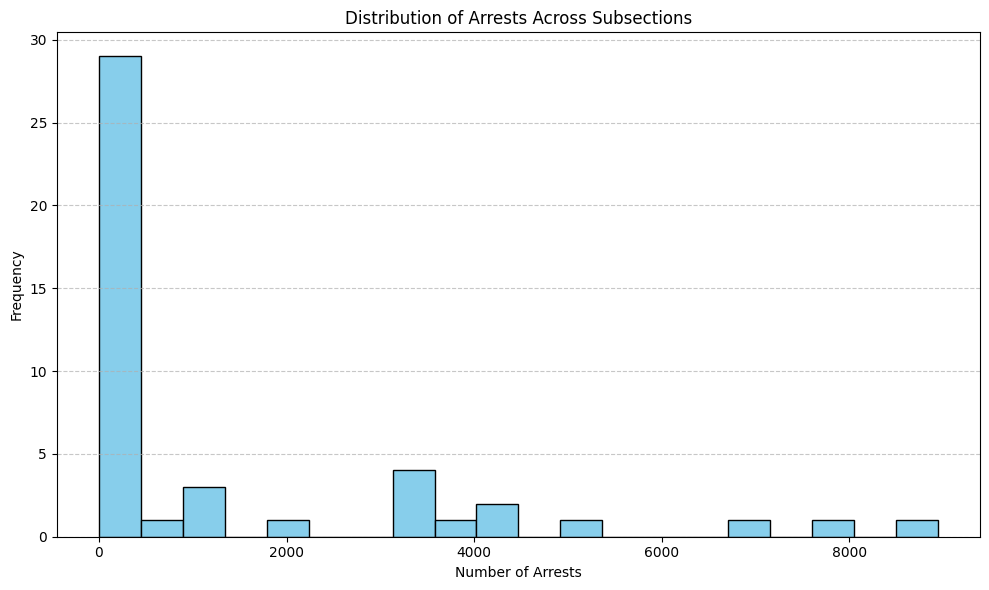

In [204]:
# Visualize the distribution of arrests across subsections
plt.figure(figsize=(10, 6))
plt.hist(df["arrests"], bins=20, color="skyblue", edgecolor="black")
plt.xlabel("Number of Arrests")
plt.ylabel("Frequency")
plt.title("Distribution of Arrests Across Subsections")
plt.grid(axis="y", linestyle="--", alpha=0.7)  # Add a light grid for better readability
plt.tight_layout()  # Adjust layout to prevent clipping

#### Visualize the Target Variable's Correlation with Each Feature Individually

To better understand how each feature relates to the target variable (`arrests`), we visualize the correlations between the target and all input features.

This analysis helps us:

- Identify strong linear or non-linear relationships.
- Detect potential outliers that could affect the model.
- Determine which features might require additional engineering or transformation.

The inclusion of correlation coefficients provides quantitative insights into these relationships, complementing the visual patterns.


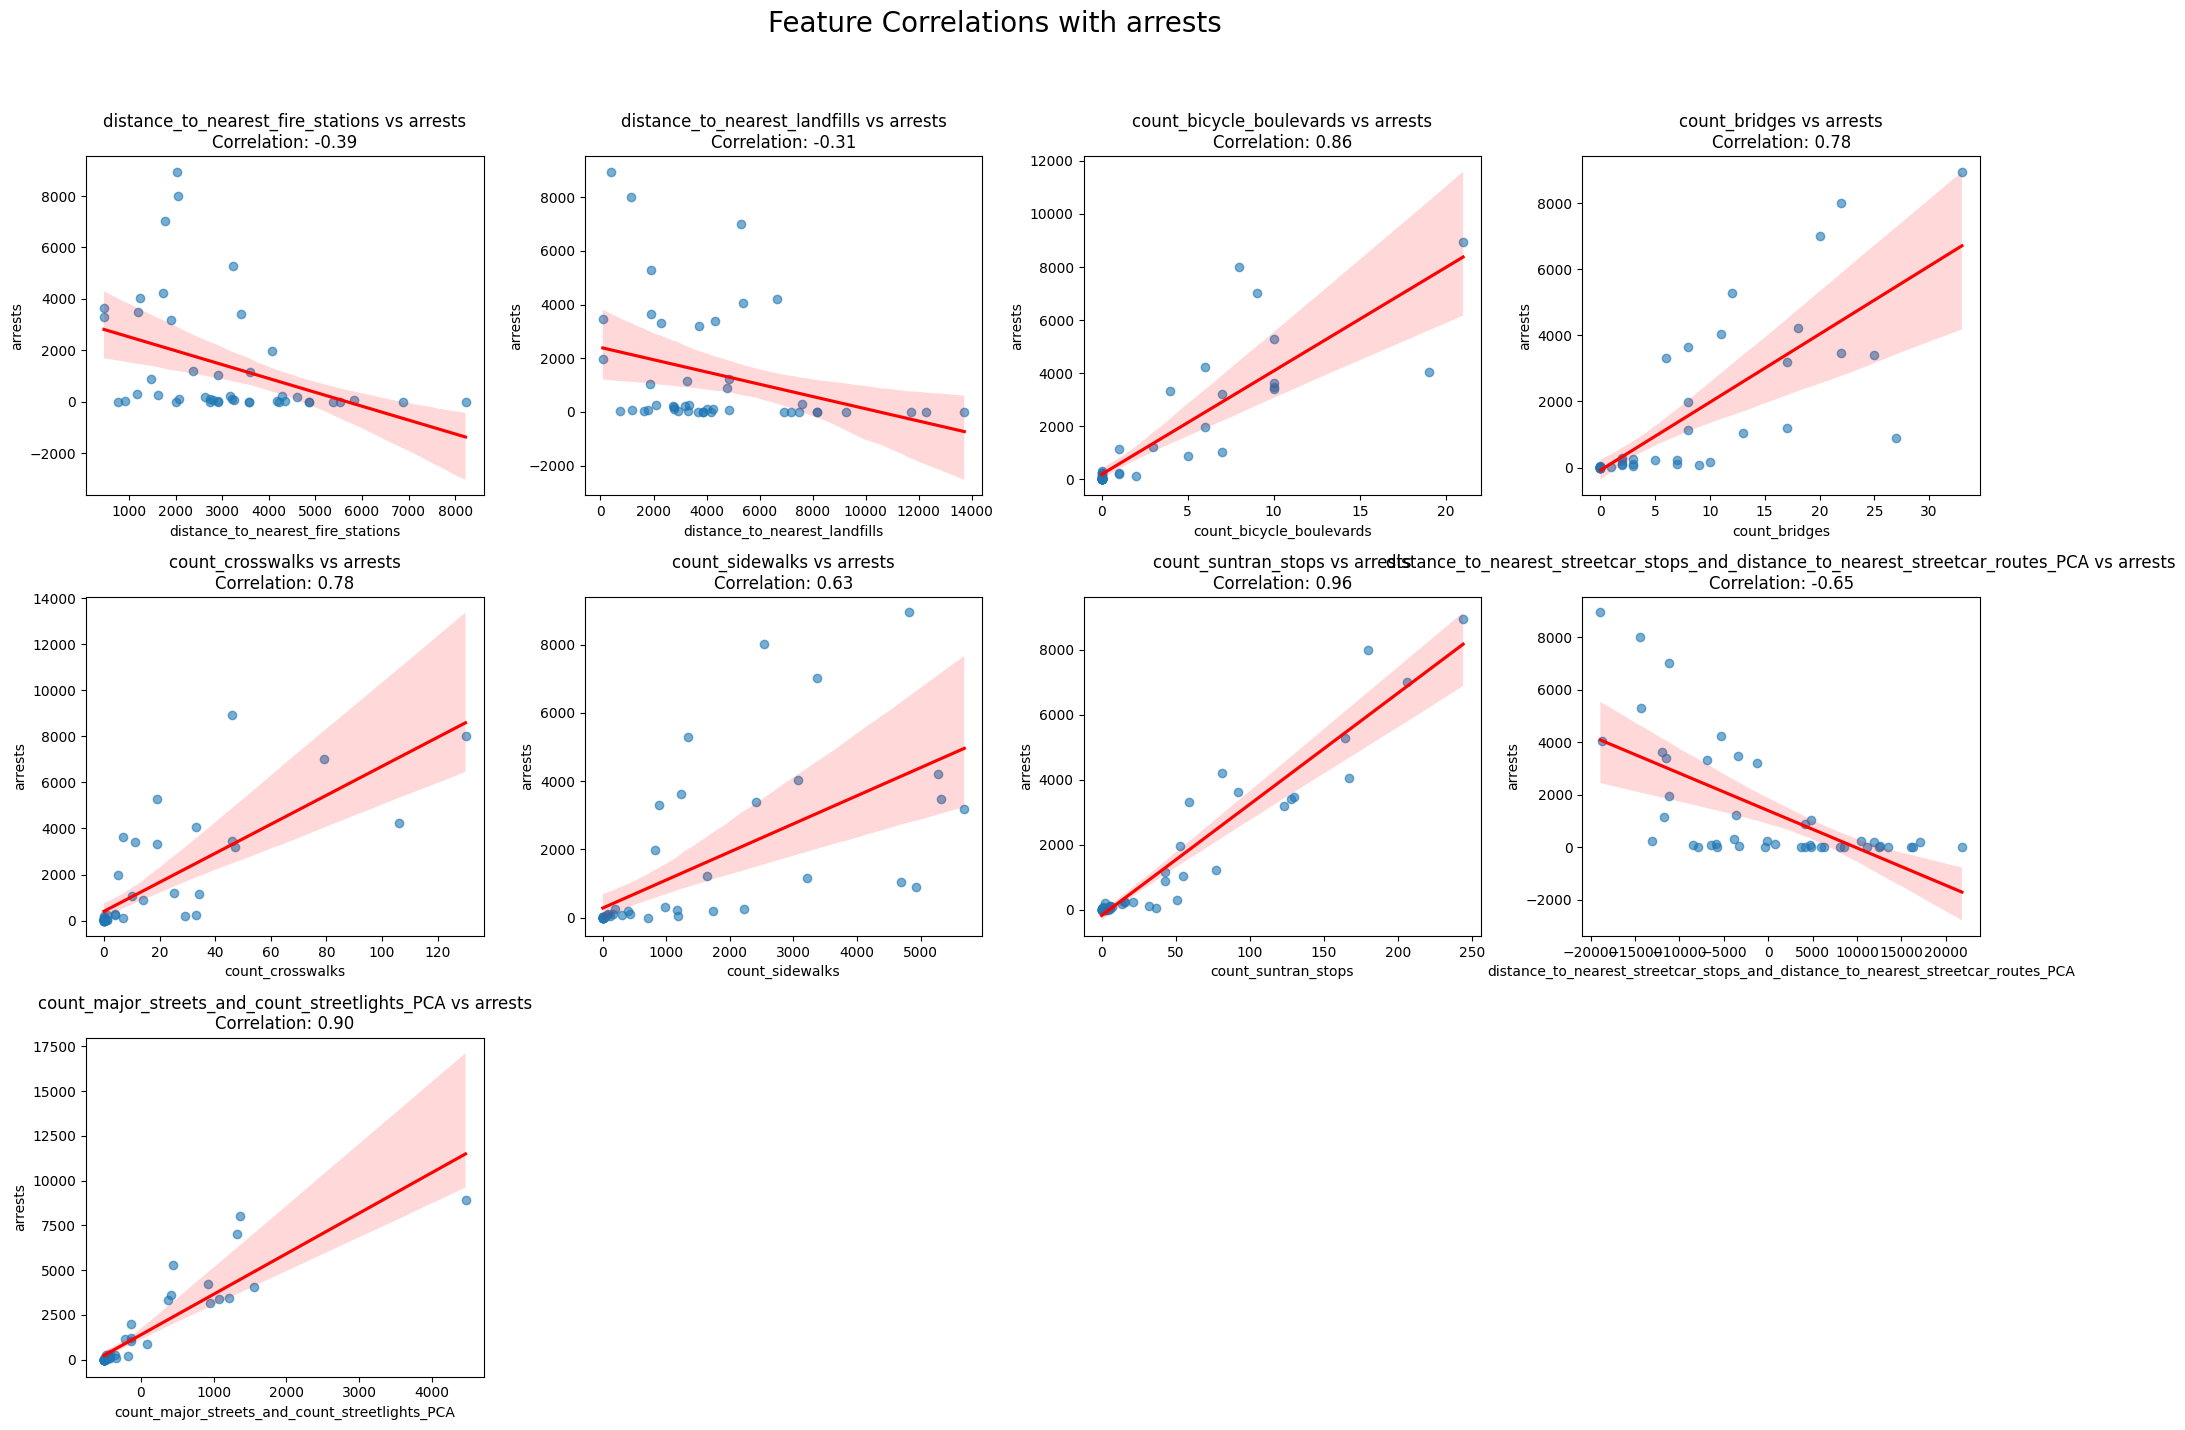

In [205]:
def visualize_feature_correlations(dataframe: pd.DataFrame, target_feature: str):
    """
    Visualize relationships between the target variable and all other features.

    Parameters:
    dataframe (pd.DataFrame): The input DataFrame containing features and the target variable.
    target_feature (str): The column name of the target variable.

    Returns:
    None
    """
    features = [col for col in dataframe.columns if col != target_feature]
    num_features = len(features)
    num_cols = 4  # Number of columns for subplots
    num_rows = (num_features + num_cols - 1) // num_cols  # Dynamically calculate rows

    # Create a grid of subplots
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))
    fig.suptitle(f"Feature Correlations with {target_feature}", fontsize=20)
    axs = axs.flatten()  # Flatten axes array for easier indexing

    # Iterate through features to plot correlations
    for i, feature in enumerate(features):
        ax = axs[i]

        # Compute correlation coefficient for numeric features
        corr_coef = (
            dataframe[feature].corr(dataframe[target_feature])
            if pd.api.types.is_numeric_dtype(dataframe[feature])
            else None
        )

        if pd.api.types.is_numeric_dtype(dataframe[feature]):
            # Plot numeric features with regression line
            sns.regplot(
                x=dataframe[feature],
                y=dataframe[target_feature],
                ax=ax,
                scatter_kws={"alpha": 0.6},
                line_kws={"color": "red"},
            )
            ax.set_title(f"{feature} vs {target_feature}\nCorrelation: {corr_coef:.2f}")
        else:
            # Plot categorical features with boxplots
            sns.boxplot(x=dataframe[feature], y=dataframe[target_feature], ax=ax)
            ax.set_title(f"{feature} vs {target_feature}")

        ax.set_xlabel(feature)
        ax.set_ylabel(target_feature)

    # Hide unused subplots
    for j in range(i + 1, len(axs)):
        axs[j].set_visible(False)

    # Adjust layout for readability
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


# Call the function to visualize correlations
visualize_feature_correlations(df, "arrests")

## Model Training

### Split Data into Training and Testing Sets

Before training the model, the dataset is divided into training and testing subsets. This ensures that model evaluation is performed on unseen data, reducing the risk of overfitting and providing a realistic estimate of the model's performance.

The split ratio is defined in the configuration file (`test_size`), which determines the proportion of data reserved for testing. Here, 20% of the data is used for testing, as per the hyperparameter `test_size`.

In [206]:
# Split the dataset into training and testing subsets
train, test = train_test_split(
    df,
    test_size=config["hp"]["test_size"],
    random_state=42,  # Ensures reproducibility of the split
)

# Confirm the split sizes
print(f"Training set size: {len(train)} samples")
print(f"Testing set size: {len(test)} samples")

Training set size: 36 samples
Testing set size: 9 samples


### Normalize Data

By scaling the data, we ensure that all features contribute equally to the model, preventing any single feature from disproportionately influencing the results due to its magnitude.

Here, the data is normalized using `StandardScaler`, which standardizes features by removing the mean and scaling to unit variance. This is performed **after the train-test split** to prevent data leakage, ensuring that the test set remains unseen during model training.


In [207]:
# Select feature columns for scaling
X_features = df.columns[:-1]  # All columns except the target ('arrests')
features = df.columns  # All columns including the target for consistent scaling

# Initialize the StandardScaler and fit it to the training data
scaler = StandardScaler().fit(train[features])

# Apply the scaler to the training and testing datasets
# Scaling is performed separately to avoid data leakage
train[features] = scaler.transform(train[features])
test[features] = scaler.transform(test[features])

# Verify the scaling process by checking mean and standard deviation
print("Training data mean (post-scaling):")
print(train[features].mean(axis=0))

print("\nTraining data standard deviation (post-scaling):")
print(train[features].std(axis=0).round(6))

Training data mean (post-scaling):
distance_to_nearest_fire_stations                                                   6.090807e-17
distance_to_nearest_landfills                                                      -4.625929e-17
count_bicycle_boulevards                                                            0.000000e+00
count_bridges                                                                      -5.859510e-17
count_crosswalks                                                                   -9.560254e-17
count_sidewalks                                                                    -6.476301e-17
count_suntran_stops                                                                -2.081668e-17
distance_to_nearest_streetcar_stops_and_distance_to_nearest_streetcar_routes_PCA   -9.251859e-18
count_major_streets_and_count_streetlights_PCA                                     -7.709882e-18
arrests                                                                             4.934325

#### Split Data into Input ($X$) and Output ($y$) Data

To prepare the dataset for model training, we split it into input features ($X$) and the target variable ($y$). Here:

- **$X$ (input features):** All columns except the target variable.
- **$y$ (target variable):** The column representing crime frequency (`arrests`).


In [208]:
# Define the target feature
target_feature_name = "arrests"

# Separate input features (X) and target variable (y) for training and testing datasets
X_train, y_train = train.drop(columns=[target_feature_name]), train[target_feature_name]
X_test, y_test = test.drop(columns=[target_feature_name]), test[target_feature_name]

# Verify the shapes of the resulting datasets
print(f"Training input shape: {X_train.shape}, Training target shape: {y_train.shape}")
print(f"Testing input shape: {X_test.shape}, Testing target shape: {y_test.shape}")

Training input shape: (36, 9), Training target shape: (36,)
Testing input shape: (9, 9), Testing target shape: (9,)


### Hyperparameter Tuning and Model Selection

For the first model, we evaluate three types of linear regression models:

1. **Best Subset Regression:** Explores all possible combinations of features to identify the subset that maximizes the $R^2$ score.
2. **Ridge Regression:** Includes an $L_2$ regularization term to prevent overfitting by penalizing large coefficients.
3. **Lasso Regression:** Employs $L_1$ regularization to enforce sparsity, potentially setting some feature coefficients to zero.

To determine the best model, we evaluate their performance using $R^2$ scores. For Best Subset Regression, we systematically test all subsets of features, calculate cross-validated $R^2$ scores, and track the subset size and its corresponding performance.


In [209]:
# Initialize the linear regression model for Best Subset Regression
best_subsets_lr = LinearRegression()

# Variables to store subset sizes and corresponding R^2 scores
subset_sizes = []
r2_means_subsets = []

# Iterate through all possible subset sizes
for subset_size in range(1, len(X_features) + 1):
    subsets = combinations(
        X_features, subset_size
    )  # Generate all subsets of the current size

    # Calculate the mean R^2 score for each subset
    for subset in subsets:
        subset = list(subset)  # Convert tuple to list for compatibility
        mean_r2 = cross_val_score(
            best_subsets_lr,
            X_train[subset],
            y_train,
            cv=config["hp"]["cross_val_folds"]["best_subset"],
            scoring=config["hp"]["scoring_metric"]["best_subset"],
        ).mean()
        subset_sizes.append(subset_size)
        r2_means_subsets.append((mean_r2, subset))

# Display the total number of subsets evaluated
print(f"Evaluated {len(r2_means_subsets)} feature subsets.")

Evaluated 511 feature subsets.


#### Visualize the General Performance of Each Subset Size

To evaluate the effectiveness of feature subsets, we visualize the $R^2$ scores achieved by subsets of varying sizes. This helps identify the subset size that optimally balances model complexity and predictive performance.


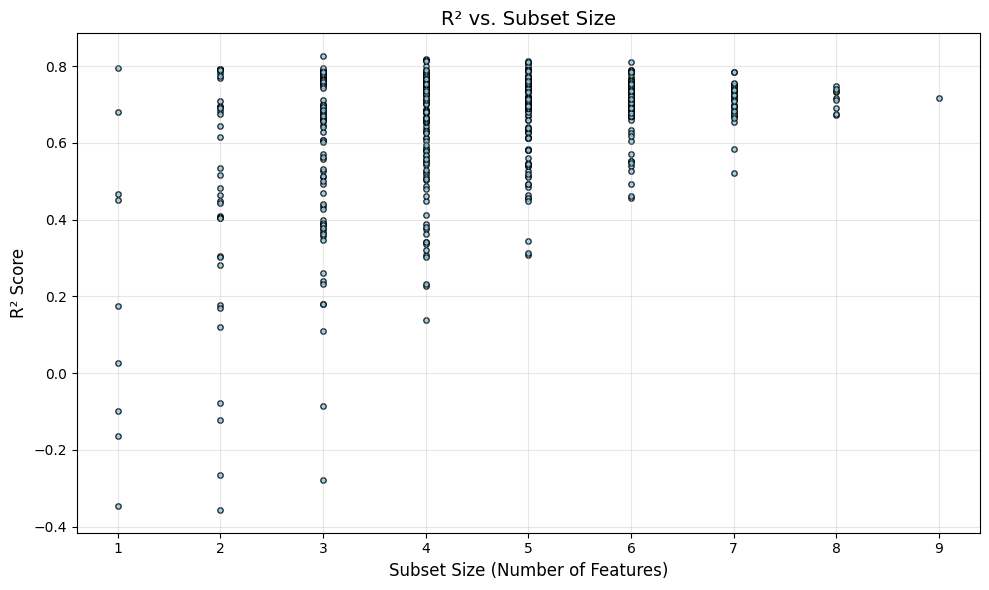

In [210]:
# Extract R² scores for each subset size
subset_sizes_list = [size for size in subset_sizes]
r2_scores_list = [r2 for r2, _ in r2_means_subsets]

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(
    subset_sizes_list,
    r2_scores_list,
    alpha=0.8,
    s=15,
    color="skyblue",
    edgecolor="black",
)
plt.xlabel("Subset Size (Number of Features)", fontsize=12)
plt.ylabel("R² Score", fontsize=12)
plt.title("R² vs. Subset Size", fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()

##### Determine the Best-Performing Subset Size

Using the calculated $R^2$ scores, we identify the feature subset that achieves the highest predictive performance. This provides a balance between model simplicity and accuracy.

In [211]:
# Sort subsets by descending R² score and extract the best-performing subset
best_r2_subset_2, best_feature_combo = sorted(r2_means_subsets, key=lambda x: -x[0])[0]

# Display the results
print("Best-Performing Subset of Features:")
print(f"Features: {best_feature_combo}")
print(f"R² Score: {best_r2_subset_2:.4f}")

Best-Performing Subset of Features:
Features: ['count_crosswalks', 'count_sidewalks', 'count_suntran_stops']
R² Score: 0.8261


#### Ridge Regression

To determine the optimal regularization parameter ($\alpha$) for Ridge Regression, we evaluate model performance across a range of 50 logarithmically spaced $\alpha$ values within $[10^{-1}, 10^{3}]$. For each $\alpha$, we calculate the mean and standard deviation of $R^2$ scores using cross-validation.

In [212]:
# Generate a logarithmically spaced range of 50 alpha values between 10^-1 and 10^3
alpha_values = np.logspace(-1, 3, 50)

# Initialize lists to store mean and standard deviation of R² scores for each alpha
r2_means_ridge, r2_stds_ridge = [], []

# Iterate over alpha values and compute cross-validated R² scores
for alpha in alpha_values:
    ridge_model = linear_model.Ridge(alpha=alpha)
    r2_scores = cross_val_score(
        ridge_model,
        X_train,
        y_train,
        cv=config["hp"]["cross_val_folds"]["ridge"],
        scoring=config["hp"]["scoring_metric"]["ridge"],
    )
    r2_means_ridge.append(r2_scores.mean())  # Store mean R² score
    r2_stds_ridge.append(r2_scores.std())  # Store standard deviation of R² scores

##### Visualize Ridge Regression Performance

The performance of Ridge Regression is visualized by plotting the average $R^2$ scores for each $\alpha$ value on a logarithmic scale. Error bars indicate the standard deviation of $R^2$ scores across cross-validation folds.

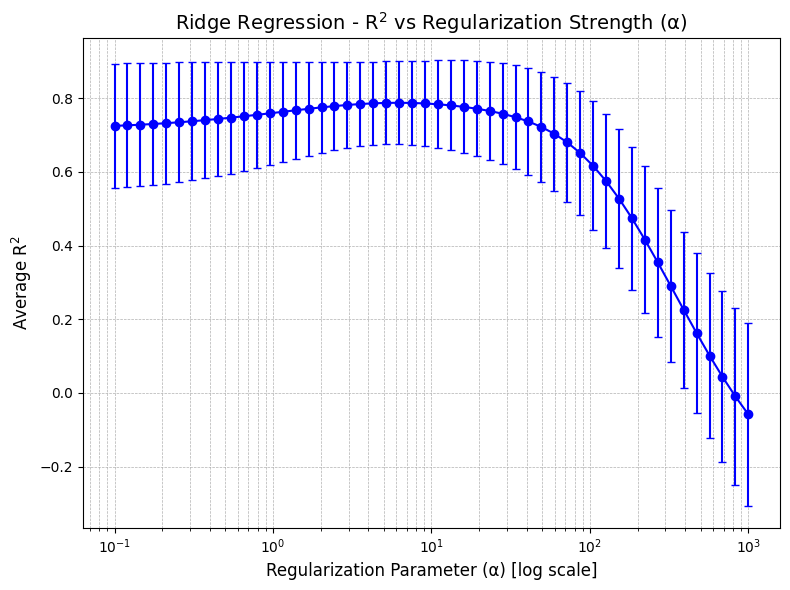

In [213]:
# Visualize the performance of Ridge Regression for different alpha values
plt.figure(figsize=(8, 6))
plt.errorbar(
    alpha_values, r2_means_ridge, yerr=r2_stds_ridge, fmt="-o", capsize=3, color="blue"
)
plt.xscale("log")  # Set x-axis to logarithmic scale
plt.title("Ridge Regression - $R^2$ vs Regularization Strength (α)", fontsize=14)
plt.xlabel("Regularization Parameter (α) [log scale]", fontsize=12)
plt.ylabel("Average $R^2$", fontsize=12)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)  # Add gridlines
plt.tight_layout()

##### Determine the Best-Performing Regularization Parameter (α)

The optimal regularization parameter $\alpha$ for Ridge Regression is determined by identifying the $\alpha$ value that yields the highest average $R^2$ score across cross-validation folds.

In [214]:
# Find the best-performing alpha value for Ridge Regression
best_r2_ridge = max(r2_means_ridge)
best_alpha_ridge = alpha_values[np.argmax(r2_means_ridge)]

# Display the results
print(f"Best R²: {best_r2_ridge:.3f}")
print(f"Best α (Regularization Parameter): {best_alpha_ridge:.3f}")

Best R²: 0.788
Best α (Regularization Parameter): 6.251


#### Lasso

In [215]:
reg_lasso_lars = linear_model.LassoLarsCV(cv=config["hp"]["cross_val_folds"]["lasso"])
reg_lasso_lars.fit(X_train, y_train)
reg_lasso_lars.coef_

array([ 0.01649396, -0.03661831,  0.09055428,  0.        ,  0.30460641,
       -0.17729898,  0.53646454, -0.00649058,  0.26606934])

Visualize the performance of each regularization coefficient

Text(0, 0.5, 'Average MSE for 20-fold CV')

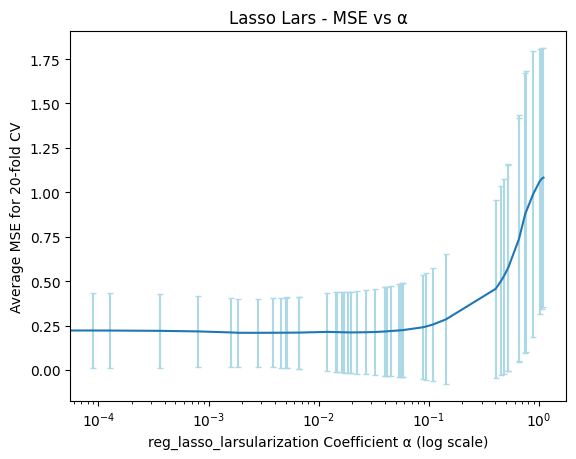

In [216]:
# Plot the MSE for each α value
plt.errorbar(
    reg_lasso_lars.cv_alphas_,  # = α values
    reg_lasso_lars.mse_path_.mean(axis=1),  # = mean of MSE for each α across 20 folds
    yerr=reg_lasso_lars.mse_path_.std(
        axis=1
    ),  # = standard deviation of MSE for each α across 20 folds
    fmt="-",
    capsize=2,
    ecolor="lightblue",
)
plt.xscale("log")
plt.title("Lasso Lars - MSE vs α")
plt.xlabel("reg_lasso_larsularization Coefficient α (log scale)")
plt.ylabel("Average MSE for 20-fold CV")

##### Determine the best-performing regularization coefficient value

In [217]:
# report the best alpha and the corresponding MSE
best_alpha_lasso = reg_lasso_lars.alpha_
best_mse_lasso = reg_lasso_lars.mse_path_.mean(axis=1)[
    np.where(reg_lasso_lars.cv_alphas_ == best_alpha_lasso)
][0]
print(f"Best α: {best_alpha_lasso:.4f}\nMSE: {best_mse_lasso:.4f}")

Best α: 0.0028
MSE: 0.2089


Add a bar to visualize where the best-performing regularization coefficient is on the graph

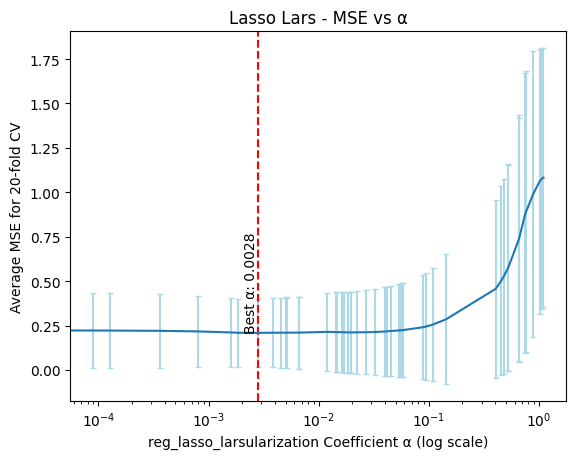

In [218]:
# Plot the MSE for each α value
plt.errorbar(
    reg_lasso_lars.cv_alphas_,  # = α values
    reg_lasso_lars.mse_path_.mean(axis=1),  # = mean of MSE for each α across 20 folds
    yerr=reg_lasso_lars.mse_path_.std(
        axis=1
    ),  # = standard deviation of MSE for each α across 20 folds
    fmt="-",
    capsize=2,
    ecolor="lightblue",
)
plt.xscale("log")
plt.title("Lasso Lars - MSE vs α")
plt.xlabel("reg_lasso_larsularization Coefficient α (log scale)")
plt.ylabel("Average MSE for 20-fold CV")

# Highlight best alpha on plot
plt.axvline(best_alpha_lasso, color="red", linestyle="--")
plt.text(
    best_alpha_lasso,
    best_mse_lasso,
    f"Best α: {best_alpha_lasso:.4f}",
    rotation=90,
    va="bottom",
    ha="right",
);

### Model Evaluation

Once all three models have been trained and hyperparameters tuned, they are evaluated on the test data. This ensures that their performance generalizes beyond the training set.

#### Best Subset Regression

The best subset regression model is evaluated using the optimal feature set identified earlier. Key metrics such as $R^2$ and Mean Squared Error (MSE) are calculated to assess the model's performance.

In [219]:
# Train the Best Subsets model on the optimal feature set
best_subsets_lr = linear_model.LinearRegression()
best_subsets_lr.fit(X_train[list(best_feature_combo)], y_train)

# Evaluate the model on the test data
r2_best_subsets = best_subsets_lr.score(X_test[list(best_feature_combo)], y_test)
preds_best_subsets = best_subsets_lr.predict(X_test[list(best_feature_combo)])
mse_best_subsets = sklearn.metrics.mean_squared_error(y_test, preds_best_subsets)

# Display evaluation metrics
print(
    "Best Subsets Evaluation:",
    f"Features Used: {best_feature_combo}",
    f"Coefficients: {best_subsets_lr.coef_}",
    f"Mean Squared Error (MSE): {mse_best_subsets:.3f}",
    f"R² Score: {r2_best_subsets:.3f}",
    sep="\n",
)

# Perform an additional statistical summary using statsmodels
X_train_sm = sm.add_constant(X_train[list(best_feature_combo)])
model = sm.OLS(y_train, X_train_sm).fit()
print(model.summary())

Best Subsets Evaluation:
Features Used: ['count_crosswalks', 'count_sidewalks', 'count_suntran_stops']
Coefficients: [ 0.26944407 -0.13910593  0.87068815]
Mean Squared Error (MSE): 0.042
R² Score: 0.959
                            OLS Regression Results                            
Dep. Variable:                arrests   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     171.1
Date:                Tue, 10 Dec 2024   Prob (F-statistic):           8.88e-20
Time:                        23:34:33   Log-Likelihood:              -0.040984
No. Observations:                  36   AIC:                             8.082
Df Residuals:                      32   BIC:                             14.42
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
       

#### Ridge Regression

Using the optimal $\alpha$ value determined during hyperparameter tuning, we evaluate the Ridge Regression model. Key metrics such as $R^2$ and Mean Squared Error (MSE) are calculated to assess its performance on the test data.


In [220]:
# Train the Ridge Regression model with the best alpha value
reg_ridge = linear_model.Ridge(alpha=best_alpha_ridge)
reg_ridge.fit(X_train, y_train)

# Evaluate the model on the test data
r2_ridge = reg_ridge.score(X_test, y_test)
preds_ridge = reg_ridge.predict(X_test)
mse_ridge = sklearn.metrics.mean_squared_error(y_test, preds_ridge)

# Display evaluation metrics
print(
    "Ridge Regression Evaluation:",
    f"Coefficients: {reg_ridge.coef_}",
    f"Optimal α (alpha): {best_alpha_ridge:.3f}",
    f"Mean Squared Error (MSE): {mse_ridge:.3f}",
    f"R² Score: {r2_ridge:.3f}",
    sep="\n",
)

Ridge Regression Evaluation:
Coefficients: [ 0.02419366 -0.04124107  0.17618552  0.05782215  0.27203466 -0.1039813
  0.3078223  -0.07213951  0.24599121]
Optimal α (alpha): 6.251
Mean Squared Error (MSE): 0.044
R² Score: 0.958


#### Lasso Regression

Using the optimal $\alpha$ value determined during hyperparameter tuning, we evaluate the Lasso Regression model. This step assesses the model's performance on the test data, focusing on key metrics such as $R^2$, Mean Squared Error (MSE), and the impact of feature selection via regularization.


In [221]:
# Train the Lasso Regression model with the optimal alpha value
reg_lasso = linear_model.Lasso(alpha=best_alpha_lasso)
reg_lasso.fit(X_train, y_train)

# Evaluate the model on the test data
r2_lasso = reg_lasso.score(X_test, y_test)
preds_lasso = reg_lasso.predict(X_test)
mse_lasso = sklearn.metrics.mean_squared_error(y_test, preds_lasso)

# Display evaluation metrics
print(
    "Lasso Regression Evaluation:",
    f"Coefficients: {reg_lasso.coef_}",
    f"Optimal α (alpha): {reg_lasso.alpha:.3f}",
    f"Mean Squared Error (MSE): {mse_lasso:.3f}",
    f"R² Score: {r2_lasso:.3f}",
    sep="\n"
)


Lasso Regression Evaluation:
Coefficients: [ 0.01643655 -0.03655038  0.08999424  0.          0.3044009  -0.17726365
  0.53693242 -0.00649942  0.26623392]
Optimal α (alpha): 0.003
Mean Squared Error (MSE): 0.015
R² Score: 0.986


### Compare Feature Weights for each Model

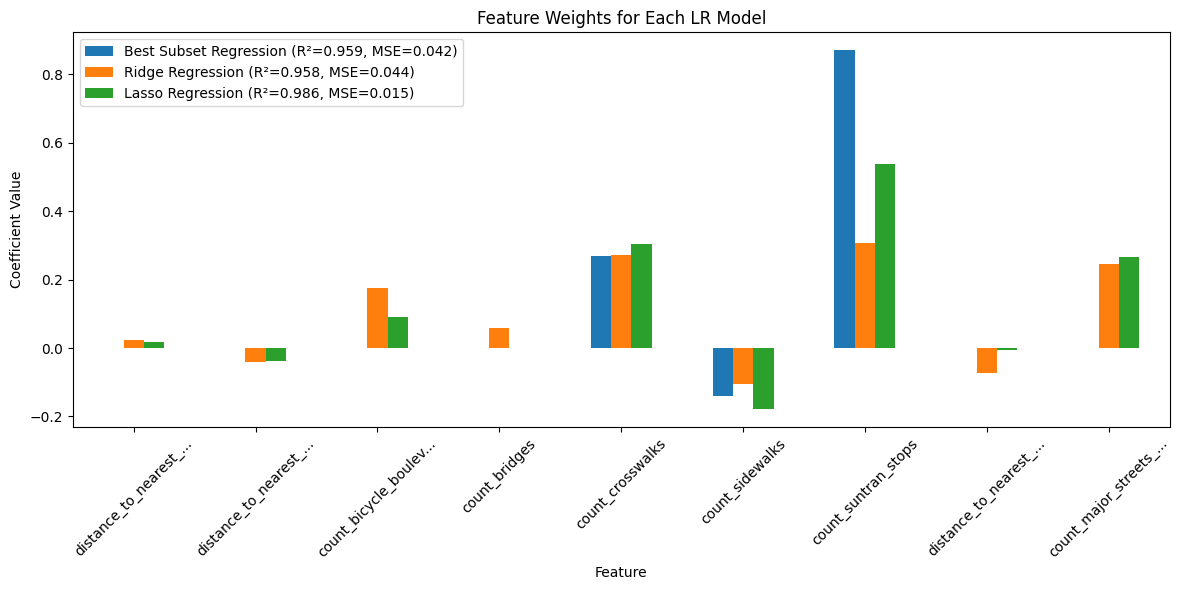

In [222]:
feature_names = df.columns[:-1]
model_names = [
    f"Best Subset Regression (R²={r2_best_subsets:.3f}, MSE={mse_best_subsets:.3f})",
    f"Ridge Regression (R²={r2_ridge:.3f}, MSE={mse_ridge:.3f})",
    f"Lasso Regression (R²={r2_lasso:.3f}, MSE={mse_lasso:.3f})",
]
results_df = pd.DataFrame(columns=model_names, index=feature_names)
for i, feature in enumerate(feature_names):
    results_df.loc[feature] = [
        (
            best_subsets_lr.coef_[list(best_feature_combo).index(feature)]
            if feature in best_feature_combo
            else 0
        ),
        reg_ridge.coef_[i],
        reg_lasso.coef_[i],
    ]

# Create a plot of the coefficients for each model
metrics_df = pd.DataFrame(columns=model_names, index=["MSE", "R²"])
metrics_df.loc["MSE"] = [mse_best_subsets, mse_ridge, mse_lasso]
metrics_df.loc["R²"] = [r2_best_subsets, r2_ridge, r2_lasso]

# Use truncated labels for better readability
truncated_labels = [
    label[:20] + "..." if len(label) > 20 else label for label in results_df.index
]
results_df.index = truncated_labels

# Create a bar plot of the coefficients for each model
results_df.plot(kind="bar", figsize=(12, 6))
plt.title("Feature Weights for Each LR Model")
plt.ylabel("Coefficient Value")
plt.xlabel("Feature")
plt.xticks(rotation=45)
plt.tight_layout()

#### Visualize Model Performance

We visualize the performance of the best-performing model, Lasso Regression, using two key plots:

1. **Residual Plot**: Highlights the distribution of residuals (errors between actual and predicted values) to identify potential patterns or biases in the model.
2. **Predicted vs Actual Plot**: Displays the relationship between predicted and actual values, providing a visual indication of model accuracy and potential outliers.

Performance metrics, including $R^2$ and Mean Squared Error (MSE), are also included for reference.

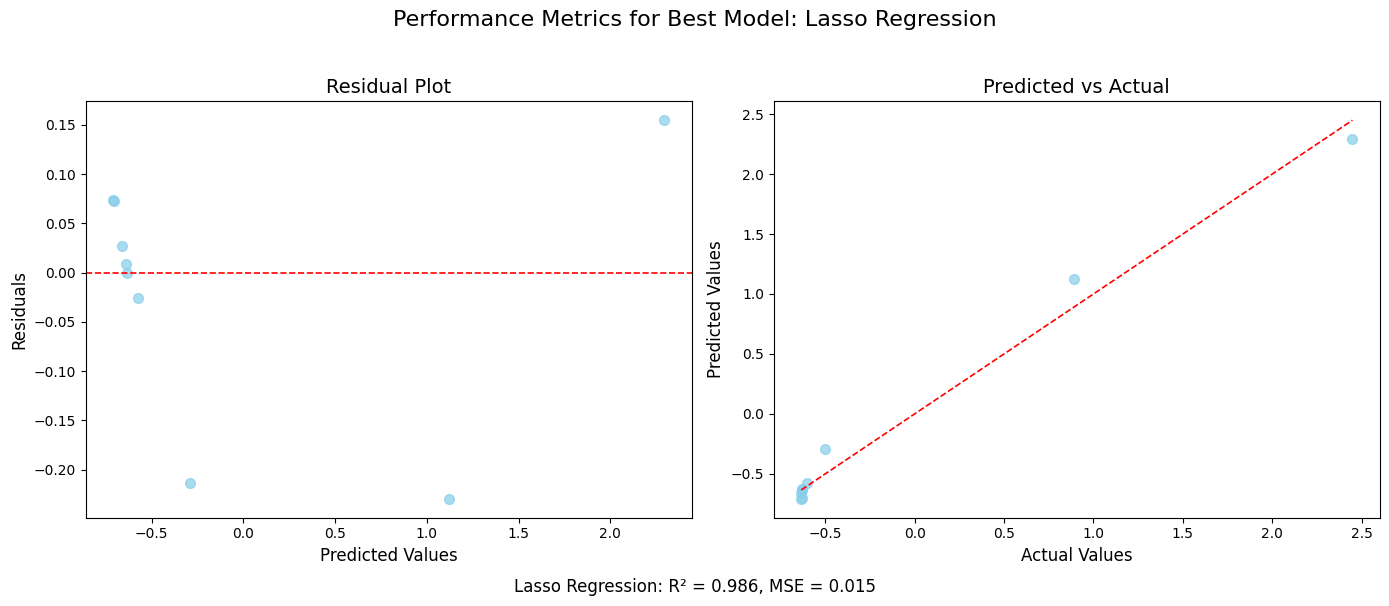

In [223]:
# Calculate residuals
residuals = y_test - preds_lasso

# Create the figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("Performance Metrics for Best Model: Lasso Regression", fontsize=16)

# Subplot 1: Residual Plot
axes[0].scatter(preds_lasso, residuals, color="skyblue", alpha=0.7, s=50)
axes[0].axhline(y=0, color="red", linestyle="--", linewidth=1.2)
axes[0].set_title("Residual Plot", fontsize=14)
axes[0].set_xlabel("Predicted Values", fontsize=12)
axes[0].set_ylabel("Residuals", fontsize=12)

# Subplot 2: Predicted vs Actual
axes[1].scatter(y_test, preds_lasso, color="skyblue", alpha=0.7, s=50)
axes[1].plot(
    [min(y_test), max(y_test)],
    [min(y_test), max(y_test)],
    color="red",
    linestyle="--",
    linewidth=1.2,
)
axes[1].set_title("Predicted vs Actual", fontsize=14)
axes[1].set_xlabel("Actual Values", fontsize=12)
axes[1].set_ylabel("Predicted Values", fontsize=12)

# Display metrics in a text box below the plots
metrics_text = f"Lasso Regression: R² = {r2_lasso:.3f}, MSE = {mse_lasso:.3f}"
plt.figtext(
    0.5, 0.01, metrics_text, wrap=True, horizontalalignment="center", fontsize=12
)

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

# Model 2—Subsection-Level Sociodemographic Features Prediction from Crime Density Features

## Exploratory Data Analysis and Data Visualization

This model predicts neighborhood-level sociodemographic features, specifically education levels, based on crime density data. The education dataset is organized by neighborhood partitions, which are sparse and do not align neatly with a uniform grid.

To begin, we load the dataset and explore its structure. Initially, we treat neighborhoods as the data items (subsections) for the model to evaluate its baseline performance.


In [224]:
# Load the education dataset
education_data = load_dataset("education")

# Preview the first few rows of the dataset
education_data.head()

OBJECTID              NAME  WARD     DATASOURCE ID sourceCountry  \
0         1        A Mountain     1  NEIGHBORHOODS  0            US   
1         2          Adelanto     3  NEIGHBORHOODS  1            US   
2         3  Alvernon Heights     5  NEIGHBORHOODS  2            US   
3         4             Amphi     3  NEIGHBORHOODS  3            US   
4         5       Armory Park     6  NEIGHBORHOODS  4            US   

   ENRICH_FID                  aggregationMethod  \
0           1  BlockApportionment:US.BlockGroups   
1           2  BlockApportionment:US.BlockGroups   
2           3  BlockApportionment:US.BlockGroups   
3           4  BlockApportionment:US.BlockGroups   
4           5  BlockApportionment:US.BlockGroups   

   populationToPolygonSizeRating  apportionmentConfidence  ...  NOHS_CY  \
0                          2.191                    2.576  ...      382   
1                          2.191                    2.576  ...       54   
2                          2.191                    2.576  ...        3   
3                          2.191                    2.576  ...      405   
4                          2.191                    2.576  ...       65   

   SOMEHS_CY  HSGRAD_CY  GED_CY  SMCOLL_CY  ASSCDEG_CY  BACHDEG_CY  \
0        291        323     187        498         131          88   
1         34         55      17          9          10          10   
2         21         34      17         69          12          26   
3        697        954     232       1260         395         432   
4         70        138      73        287          71         404   

   GRADDEG_CY  EDUCBASECY                                           geometry  
0          13        1913  POLYGON ((-111.0076 32.20691, -111.00673 32.20...  
1          11         200  POLYGON ((-110.98426 32.24578, -110.98222 32.2...  
2           7         189  POLYGON ((-110.90819 32.20294, -110.90818 32.2...  
3         213        4588  POLYGON ((-110.97768 32.27921, -110.97731 32.2...  
4         449        1557  POLYGON ((-110.97102 32.22046, -110.97112 32.2...  

[5 rows x 21 columns]

### Clean the Data

Remove any neighborhoods with missing data (from columnds relevant to the model)

In [225]:
# Drop any rows with null values in the relevant education-level columns
relevant_cols = [
    "NOHS_CY",
    "SOMEHS_CY",
    "HSGRAD_CY",
    "GED_CY",
    "SMCOLL_CY",
    "ASSCDEG_CY",
    "BACHDEG_CY",
    "GRADDEG_CY",
]
education_data = education_data.dropna(subset=relevant_cols)

# Drop any rows with null values in the geometry (location) column
education_data = education_data.dropna(subset=["geometry"])

### Explore the Dataset

To get an idea of how best to construct features for the purpose of predicting sociodemographic features from crime density, we will visualize the dataset.

#### Visualize the Neighborhoods on the Map

Since our data items/rows will (tentatively) be neighborhoods, we start by defining a function to visualize the neighborhoods on the map.

In [226]:
def visualize_neighborhood_boundaries(
    gdf: gpd.GeoDataFrame, folium_map=None, fill_opacity=None
):
    """
    Visualizes neighborhood boundaries as polygons on a Folium map.

    Params:
    geojson_data: dict - GeoJSON data with neighborhood boundaries.
    folium_map: folium.Map - The Folium map to add boundaries to.
    fill_opacity: float - Opacity of the filled neighborhood polygons.
    line_color: str - Color of the polygon borders.

    Returns:
    folium.Map: The updated Folium map with neighborhood boundaries.
    """
    if folium_map is None:
        folium_map = folium.Map(
            location=config["tucson_center_coordinates"], zoom_start=12
        )

    # Reproject to WGS84 if not already
    if gdf.crs != "EPSG:4326":
        gdf = gdf.to_crs("EPSG:4326")

    # Add each neighborhood boundary as a polygon without fill
    for _, row in gdf.iterrows():
        geometry = row.geometry
        if geometry.geom_type == "Polygon":
            # Add a single polygon
            folium.PolyLine(
                locations=[[y, x] for x, y in geometry.exterior.coords],
                color="#9D00FF",
                fill=fill_opacity is not None,
                fill_opacity=fill_opacity,
            ).add_to(folium_map)
        elif geometry.geom_type == "MultiPolygon":
            # Add each part of a MultiPolygon
            for polygon in geometry.geoms:
                folium.PolyLine(
                    locations=[[y, x] for x, y in polygon.exterior.coords],
                    color="#9D00FF",
                    fill=fill_opacity is not None,
                    fill_opacity=fill_opacity,
                ).add_to(folium_map)

    return folium_map

In [227]:
visualize_neighborhood_boundaries(education_data, fill_opacity=0.2)

#### Visualize the Distribution of the Target Variable (Education Level) across Neighborhoods

In the dataset, the education levels per neighborhood are represented by 6 categories:

| Column Name  | Description          |
| ------------ | -------------------- |
| `GRADDEG_CY` | Graduate degree      |
| `BACHDEG_CY` | Bachelor's degree    |
| `ASSCDEG_CY` | Associate degree     |
| `SMCOLL_CY`  | Some college         |
| `GED_CY`     | GED                  |
| `HSGRAD_CY`  | High school graduate |
| `SOMEHS_CY`  | Some high school     |
| `NOHS_CY`    | No high school       |

The values in these columns are nominal counts of the number of people in each neighborhood that fall into each category.

To visualize the data, we want to first combine the columnds into a single continuous variable that represents the education level of each neighborhood. To accomplish this, we assign a weight to each category and sum the weighted counts. The weight will represent the ordinal value of the education level such that higher weights correspond to higher education levels:

| Column Name  | Weight | Description          |
| ------------ | ------ | -------------------- |
| `GRADDEG_CY` | 6      | Graduate degree      |
| `BACHDEG_CY` | 5      | Bachelor's degree    |
| `ASSCDEG_CY` | 4      | Associate degree     |
| `SMCOLL_CY`  | 3      | Some college         |
| `GED_CY`     | 2      | GED                  |
| `HSGRAD_CY`  | 1.5    | High school graduate |
| `SOMEHS_CY`  | 1      | Some high school     |
| `NOHS_CY`    | 0.5    | No high school       |


Define a function that sums the weighted counts to create a single continuous variable and then visualize the distribution of this variable across the neighborhoods:

In [228]:
# Define weights for each education level
edu_lvl_weights = {
    "GRADDEG_CY": 6,  # Graduate degree
    "BACHDEG_CY": 5,  # Bachelor's degree
    "ASSCDEG_CY": 4,  # Associate degree
    "SMCOLL_CY": 3,  # Some college
    "GED_CY": 2,  # GED
    "HSGRAD_CY": 1.5,  # High school graduate
    "SOMEHS_CY": 1,  # Some high school
    "NOHS_CY": 0.5,  # No high school
}

Create a column representing the total education counts weighted by the education level.

In [229]:
education_data["weighted_education"] = sum(
    education_data[column] * weight for column, weight in edu_lvl_weights.items()
)

Now, visualize the distribution of the total education level across the neighborhoods.

To do so, define a function that visualizes the distribution of the target variable across the neighborhoods:

In [230]:
def visualize_neighborhood_feature(
    gdf: gpd.GeoDataFrame, feature, zoom_start=12, color_scale="Blues"
):
    """
    Visualizes neighborhoods with a color gradient representing weighted education levels.

    Params:
    gdf: GeoDataFrame - GeoDataFrame with features including education levels.
    zoom_start: int - Initial zoom level of the map.
    color_scale: str - Name of a Matplotlib colormap for the gradient.

    Returns:
    folium.Map: The Folium map with filled neighborhoods based on weighted education levels.
    """
    # Normalize weighted values for color mapping
    min_val = gdf[feature].min()
    max_val = gdf[feature].max()
    norm = matplotlib.colors.Normalize(
        vmin=gdf[feature].min(), vmax=gdf[feature].max()
    )
    colormap = cm.ScalarMappable(norm=norm, cmap=color_scale)

    # Create a Folium map
    center_coords = [gdf.geometry.centroid.y.mean(), gdf.geometry.centroid.x.mean()]
    folium_map = folium.Map(location=center_coords, zoom_start=zoom_start)

    # Add polygons with color fill
    for _, row in gdf.iterrows():
        geometry = row.geometry
        weighted_value = row[feature]
        fill_color = matplotlib.colors.to_hex(colormap.to_rgba(weighted_value))

        if geometry.geom_type == "Polygon":
            # Add single polygon
            folium.Polygon(
                locations=[[y, x] for x, y in geometry.exterior.coords],
                color="black",
                fill=True,
                fill_color=fill_color,
                fill_opacity=0.7,
            ).add_to(folium_map)
        elif geometry.geom_type == "MultiPolygon":
            # Add each part of a MultiPolygon
            for polygon in geometry.geoms:
                folium.Polygon(
                    locations=[[y, x] for x, y in polygon.exterior.coords],
                    color="black",
                    fill=True,
                    fill_color=fill_color,
                    fill_opacity=0.7,
                ).add_to(folium_map)

    # Add a color scale legend
    colormap = linear.Blues_09.scale(min_val, max_val)  # Create a colormap using branca
    colormap.caption = f"{feature.title()} Level"
    colormap.add_to(folium_map)

    return folium_map

In [231]:
visualize_neighborhood_boundaries(
    education_data, visualize_neighborhood_feature(education_data, "weighted_education")
)

### Normalize Education Level by Population Size

Upon inspection of the heatmap, we notice that the lack of normalization by population size may be causing some neighborhoods to appear more educated than they actually are and generally creating too wide of a spread in the education level values.

To resolve this, we will normalize the education level by the population size of each neighborhood:

In [232]:
# Normalize the weighted education scores by population size
education_data["normalized_weighted_education"] = education_data[
    "weighted_education"
] / education_data[edu_lvl_weights.keys()].sum(axis=1)

# Preview the new columns
education_data[["weighted_education", "normalized_weighted_education"]].head()

weighted_education  normalized_weighted_education
0              3876.5                       2.026398
1               360.5                       1.802500
2               534.5                       2.828042
3             11592.5                       2.526700
4              6314.5                       4.055556

#### Visualize the Normalized Education Levels

In [233]:
visualize_neighborhood_boundaries(
    education_data,
    visualize_neighborhood_feature(education_data, "normalized_weighted_education"),
)

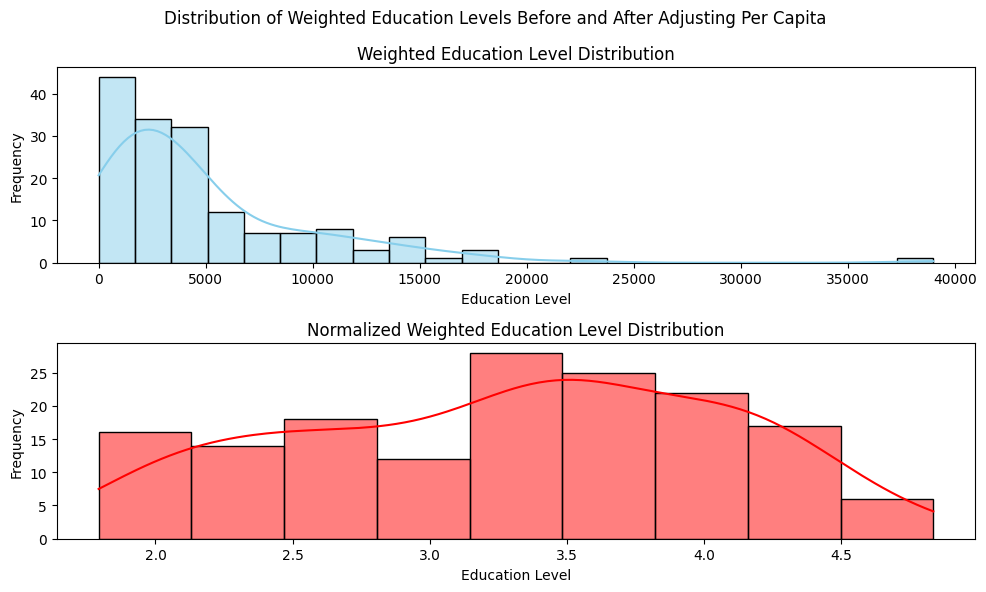

In [234]:
# plot the distribution of the normalized education levels and non-normalized education levels side-by-side.
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
fig.suptitle("Distribution of Weighted Education Levels Before and After Adjusting Per Capita")

sns.histplot(education_data["weighted_education"], kde=True, ax=ax[0], color="skyblue")
ax[0].set_title("Weighted Education Level Distribution")
ax[0].set_xlabel("Education Level")
ax[0].set_ylabel("Frequency")

sns.histplot(
    education_data["normalized_weighted_education"], kde=True, ax=ax[1], color="red"
)
ax[1].set_title("Normalized Weighted Education Level Distribution")
ax[1].set_xlabel("Education Level")
ax[1].set_ylabel("Frequency")

plt.tight_layout()

#### Plot Log-Log Distribution of the Normalized Education Levels

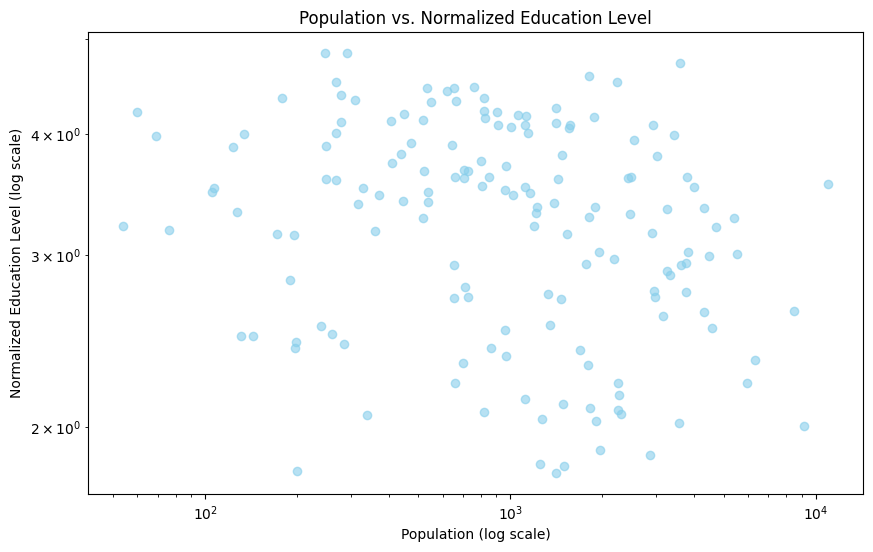

In [235]:
# Plot the log-log relationship between the population size of neighborhoods and their normalized education levels
plt.figure(figsize=(10, 6))
plt.scatter(
    education_data[edu_lvl_weights.keys()].sum(axis=1), # As before, sum the nominal education counts to infer population
    education_data["normalized_weighted_education"],
    alpha=0.6,
    color="skyblue",
)

# Add line of best fit, but can't use `linregress` module since this is a power law relationship
plt.plot(
    np.unique(education_data[edu_lvl_weights.keys()].sum(axis=1)),
    np.poly1d(
        np.polyfit(
            education_data[edu_lvl_weights.keys()].sum(axis=1),
            education_data["normalized_weighted_education"],
            1,
        )
    )(np.unique(education_data[edu_lvl_weights.keys()].sum(axis=1))),
    color="red",
)


plt.xscale("log")
plt.yscale("log")
plt.title("Population vs. Normalized Education Level")
plt.xlabel("Population (log scale)")
plt.ylabel("Normalized Education Level (log scale)")
plt.show()

The plot confirms that the distribution is not a power law distribution, which is a good sign for the model. 

### Transform Education Level into a Categorical Variable

We explore two possible ways of casting the education level as a categorical variable:

1. Taking the most common education level in each neighborhood
2. Averaging the weighted education levels and choosest the closest weight (from the weights defined above that map education levels to ordinal values)

This corresponds to the mode or mean of the education level in each neighborhood, respectively.

Create both options and compare: 

In [236]:
# Create a column representing the most common education level in each neighborhood
education_data["most_common_education"] = education_data[edu_lvl_weights.keys()].idxmax(
    axis=1
)

# Extract weights and their corresponding labels
weight_to_label = {v: k for k, v in edu_lvl_weights.items()}
weights = list(weight_to_label.keys())

# Create column representing closest ordinal value to the normalized education level
education_data["closest_education_level"] = [
    weight_to_label[min(weights, key=lambda w: abs(w - value))]
    for value in education_data["normalized_weighted_education"]
]

# Preview the newly added columns
education_data[["most_common_education", "closest_education_level"]].head()

print(education_data["normalized_weighted_education"].describe())

count    158.000000
mean       3.291363
std        0.781929
min        1.792761
25%        2.646656
50%        3.373859
75%        3.967775
max        4.837329
Name: normalized_weighted_education, dtype: float64


The preview indicates that using the most common value creates a wider range of values. Verify by plotting and comparing the distributions of the two methods:

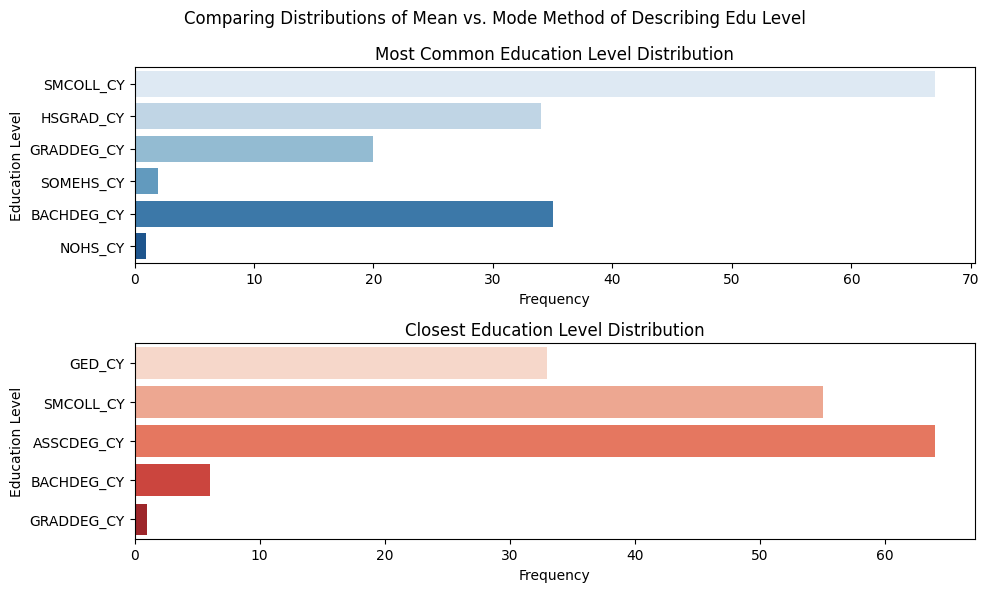

In [237]:
# Plot and compare side-by-side the distributions of most_common_education vs closest_education_level
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
fig.suptitle("Comparing Distributions of Mean vs. Mode Method of Describing Edu Level")

sns.countplot(education_data["most_common_education"], ax=ax[0], palette="Blues")
ax[0].set_title("Most Common Education Level Distribution")
ax[0].set_xlabel("Frequency")
ax[0].set_ylabel("Education Level")

sns.countplot(education_data["closest_education_level"], ax=ax[1], palette="Reds")
ax[1].set_title("Closest Education Level Distribution")
ax[1].set_xlabel("Frequency")
ax[1].set_ylabel("Education Level")

plt.tight_layout()

Since both distributions are manageable, we will use the one corresponding to mean education level for the model as it is more informative.

### Create Crime Density Features per Neighborhood

To create the input features for the model, we will use the crime density features from the first model. However, we will have to re-traverse the `arrests` dataset and sum up the number of arrests in each neighborhood.

#### Count the Number of Arrests in Each Neighborhood

In [238]:
education_data["arrests"] = [
    count_objects_in_subsection(
        load_dataset("arrests"), subsection, "arrests", use_polygon=True
    )
    for subsection in education_data.geometry
]

education_data["arrests"]  # Preview the new column

0       230
1        21
2        44
3      1994
4       278
       ... 
154      27
155      16
156    2559
157      65
158     192
Name: arrests, Length: 159, dtype: int64

#### Calculate the Proportion of Felonies vs. Misdemeanors in Each Neighborhood

The proportion of felonies vs. misdemeanors in each neighborhood can represent the severity of the crimes in each neighborhood.

In [239]:
# Add felony counts
education_data["felony_count"] = [
    count_objects_in_subsection(
        load_dataset("arrests"),
        subsection,
        "arrests",
        use_polygon=True,
        condition=lambda row: row["fel_misd"] == "F",
    )
    for subsection in education_data.geometry
]

# Add misdemeanor counts
education_data["misdemeanor_count"] = [
    count_objects_in_subsection(
        load_dataset("arrests"),
        subsection,
        "arrests",
        use_polygon=True,
        condition=lambda row: row["fel_misd"] == "M",
    )
    for subsection in education_data.geometry
]

# Calculate the proportion of felonies
education_data["prop_felonies"] = education_data["felony_count"] / (
    education_data["felony_count"] + education_data["misdemeanor_count"]
)

# If any of the proportion values are NaN (as a result of felony_count = 0), replace with 0
education_data["prop_felonies"] = education_data["prop_felonies"].fillna(0)

# Preview the updated DataFrame
education_data[["felony_count", "misdemeanor_count", "prop_felonies"]]

# print(education_data[['prop_felonies', 'arrests']].describe())
print(education_data[['prop_felonies', 'arrests']])

     prop_felonies  arrests
0         0.376682      230
1         0.050000       21
2         0.105263       44
3         0.256052     1994
4         0.137931      278
..             ...      ...
154       0.458333       27
155       0.375000       16
156       0.160622     2559
157       0.066667       65
158       0.299435      192

[159 rows x 2 columns]


#### Adjust Crime Density Per-Capita

In [240]:
# # Adjust crime density per-capita
education_data["arrests"] = education_data["arrests"] / education_data[
    edu_lvl_weights.keys()
].sum(axis=1)

# Preview the updated DataFrame
education_data["arrests"]

0       0.120230
1       0.105000
2       0.232804
3       0.434612
4       0.178548
         ...    
154     0.103448
155     0.043011
156    20.804878
157     0.451389
158     0.050646
Name: arrests, Length: 159, dtype: float64

#### Test for Extreme Outliers

During EDA we noticed some neighborhoods having extreme outlier values for the crime density features (even after controlling for population size). We will test for these outliers and remove them if necessary.

In [241]:
# Identify outliers in the arrests column
Q1 = education_data["arrests"].quantile(0.25)
Q3 = education_data["arrests"].quantile(0.75)
IQR = Q3 - Q1

# Report the number of outliers and details about each one
outliers = education_data[
    (education_data["arrests"] < Q1 - 1.5 * IQR)
    | (education_data["arrests"] > Q3 + 1.5 * IQR)
]

education_data[education_data["NAME"] == "San Ignacio Yaqui"]
print("Outliers:")
outliers[
    [
        "NAME",
        "arrests",
        "prop_felonies",
        "closest_education_level",
        "most_common_education",
    ]
].head()

Outliers:


NAME   arrests  prop_felonies  \
52                     Iron Horse  0.764516       0.174157   
80                      Pie Allen  2.763052       0.099822   
100  Santa Rita Park - West Ochoa  0.557143       0.154993   
115               West University  0.680102       0.113636   
121                     Millville  1.215385       0.136150   

    closest_education_level most_common_education  
52               ASSCDEG_CY            BACHDEG_CY  
80               ASSCDEG_CY            BACHDEG_CY  
100               SMCOLL_CY             HSGRAD_CY  
115              ASSCDEG_CY            BACHDEG_CY  
121               SMCOLL_CY             SMCOLL_CY

Remove any extreme outliers from the dataset:

In [242]:
#  Filter out outliers
education_data = education_data[
    (education_data["arrests"] >= Q1 - 1.5 * IQR)
    & (education_data["arrests"] <= Q3 + 1.5 * IQR)
]

### Normalize the Data

Since we are using SVM, we should normalize the continuous features.

In [243]:
scaler = StandardScaler()

# Scale the relevant columns
education_data[["arrests", "prop_felonies"]] = scaler.fit_transform(
    education_data[["arrests", "prop_felonies"]]
)

# Preview the scaled columns
education_data[["arrests", "prop_felonies"]].head()

arrests  prop_felonies
0 -0.320805       1.418329
1 -0.451504      -1.482012
2  0.645274      -0.991375
3  2.377128       0.347353
4  0.179667      -0.701344

### Visualize Separation into Education Level Categories from Crime Density

Get an initial idea of how well we can separate the neighborhoods into the education level categories using the crime-related features.

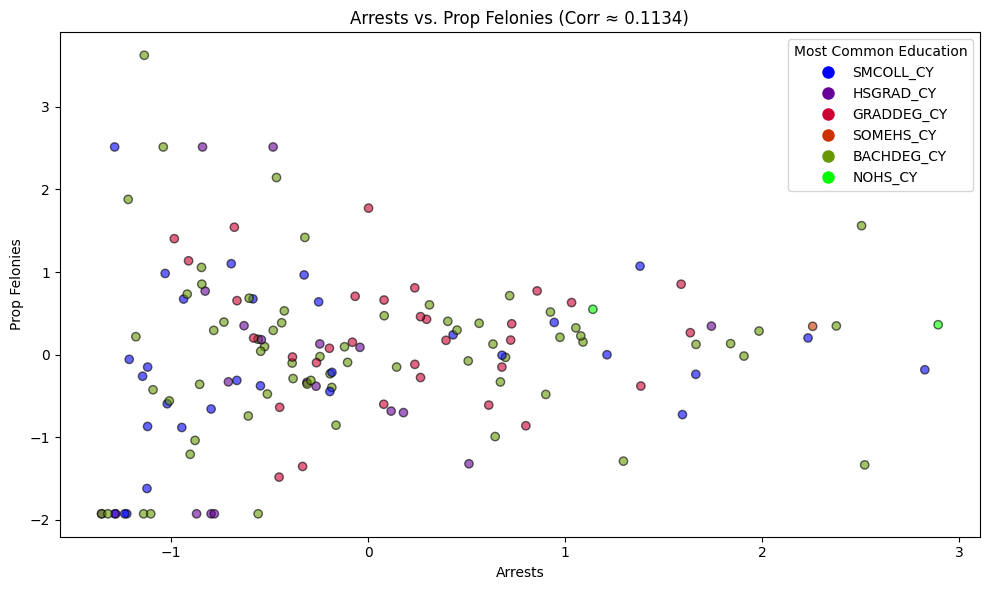

In [244]:
# Define input features and target class
feature_x = "arrests"  # Total arrests
feature_y = "prop_felonies"  # Proportion of felonies
target_class = "most_common_education"

# Create a scatter plot
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plot with color encoding by target class
scatter = ax.scatter(
    education_data[feature_x],
    education_data[feature_y],
    c=education_data[target_class]
    .astype("category")
    .cat.codes,  # Encode classes as integers
    cmap="brg",
    alpha=0.6,
    edgecolor="k",
)

# Calculate correlation coefficient
corr = np.corrcoef(education_data[feature_x], education_data[feature_y])[0, 1]

# Set axis labels, title, and colorbar
ax.set_xlabel(feature_x.replace("_", " ").title())
ax.set_ylabel(feature_y.replace("_", " ").title())
ax.set_title(
    f"{feature_x.replace('_', ' ').title()} vs. {feature_y.replace('_', ' ').title()} (Corr ≈ {corr:.4f})"
)

# Create a legend for the target classes
unique_classes = education_data[target_class].unique()
colors = scatter.cmap(np.linspace(0, 1, len(unique_classes)))

handles = [
    plt.Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label=cls,
        markersize=10,
        markerfacecolor=color,
    )
    for cls, color in zip(unique_classes, colors)
]
ax.legend(handles=handles, title="Most Common Education", loc="best")

# Show plot
plt.tight_layout()
plt.show()

### Split Data into Training and Testing Sets

In [245]:
X_train, X_test = train_test_split(
    education_data[["arrests", "prop_felonies"]],
    test_size=config["hp"]["test_size"],
    random_state=42,
)

y_train, y_test = train_test_split(
    education_data["closest_education_level"],
    test_size=config["hp"]["test_size"],
    random_state=42,
)

X_train.head() # Preview the training inputs

arrests  prop_felonies
15  -1.119285      -0.868994
131 -0.481344       0.293626
11  -0.119376       0.095452
133 -0.383589      -0.028510
51  -1.285011      -1.925921

## Train the Model

### Hyperparameter Tuning

Choose the best regularization parameter for the SVM model.

Best Accuracy:                    0.4583
Using Regularization Coefficient: 3.59e-01


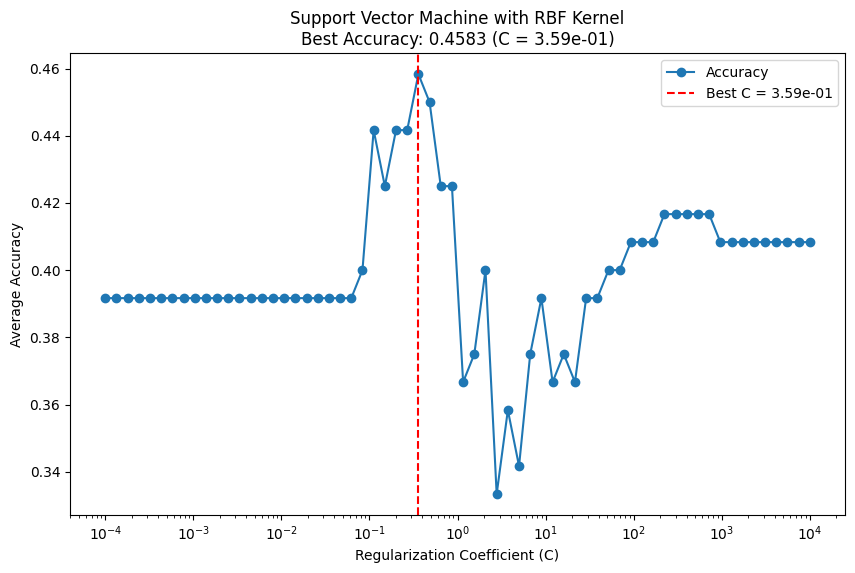

In [246]:
reg_coeff_domain = np.logspace(-4, 4, 64)  # Create a range of values

svm_scores_per_coeff = np.zeros(
    len(reg_coeff_domain)
)  # Initialize an array to store scores

for idx, coeff in enumerate(reg_coeff_domain):
    # Initialize the SVM classifier with the current C value
    svm = SVC(
        C=coeff,
        kernel="sigmoid",  # TODO: test other kernels
    )

    # Fit the classifier and calculate the score
    svm_scores_per_coeff[idx] = cross_val_score(
        svm,
        X_train,
        y_train,
        cv=config["hp"]["cross_val_folds"]["svm"],
        scoring=config["hp"]["scoring_metric"]["svm"],
    ).mean()

# Find the best accuracy and its corresponding C value
best_accuracy_idx = np.argmax(svm_scores_per_coeff)
best_score_svm = svm_scores_per_coeff[best_accuracy_idx]
best_coeff_svm = reg_coeff_domain[best_accuracy_idx]

# Plot average accuracy versus regularization coefficient
plt.figure(figsize=(10, 6))
plt.plot(
    reg_coeff_domain, svm_scores_per_coeff, marker="o", linestyle="-", label="Accuracy"
)
plt.xscale("log")
plt.xlabel("Regularization Coefficient (C)")
plt.ylabel("Average Accuracy")
plt.title(
    f"Support Vector Machine with RBF Kernel\nBest Accuracy: {best_score_svm:.4f} (C = {best_coeff_svm:.2e})"
)
plt.axvline(
    x=best_coeff_svm,
    color="red",
    linestyle="--",
    label=f"Best C = {best_coeff_svm:.2e}",
)
plt.legend()

# Report the maximum accuracy and best coefficient
print(
    f"Best Accuracy:                    {best_score_svm:.4f}",
    f"Using Regularization Coefficient: {best_coeff_svm:.2e}",
    sep="\n",
)

## Evaluate Model

### Determine Baseline Accuracy

Set the baseline for our dataset using a Majority Classifier.

Determine the proportion of the majority class in the dataset:

In [247]:
prop_majority_class = y_train.value_counts(normalize=True).max()
print(f"Proportion of Majority Class: {prop_majority_class:.4f}")

Proportion of Majority Class: 0.3917


Define function to visualize classifier performance:

In [248]:
def display_model_evaluation(
    y_true, y_pred, features, model_type, training_accuracy, regularization_coeff
):
    """
    Displays a consolidated panel with model summary and confusion matrix/classification report side-by-side using rich.
    """
    console = Console()
    class_names = [str(cls) for cls in np.unique(y_true)]
    feature_list = ", ".join(features)
    model_summary = (
        f"[bold]Model Type:[/bold]                  {model_type}\n"
        f"[bold]Features Used:[/bold]               {feature_list}\n"
        f"[bold]Regularization Coefficient:[/bold]  {regularization_coeff:.2e}\n"
        f"[bold]Accuracy on Training Data:[/bold]   {training_accuracy:.3f}\n"
        f"[bold]Accuracy of Baseline Model:[/bold]  {prop_majority_class:.3f}"
    )

    # Classification Report
    class_report = classification_report(
        y_true, y_pred, target_names=class_names, digits=2
    )
    classification_report_section = Panel(
        f"[bold green]Classification Report[/bold green]\n\n{class_report}",
        title="Classification Report",
        expand=True,
    )

    # Confusion Matrix as Formatted String
    conf_matrix = confusion_matrix(y_true, y_pred)
    column_width = max(len(cls) for cls in class_names) + 2
    header = "".join(f"{cls:<{column_width}}" for cls in [""] + class_names)
    rows = "\n".join(
        f"{class_names[i]:<{column_width}}"
        + "".join(f"{val:<{column_width}}" for val in row)
        for i, row in enumerate(conf_matrix)
    )
    conf_matrix_section = Panel(
        f"[bold cyan]Confusion Matrix[/bold cyan]\n\n{header}\n{rows}",
        title="Confusion Matrix",
        expand=True,
    )

    # Combine confusion matrix and classification report side-by-side
    side_by_side_content = Columns([conf_matrix_section, classification_report_section])

    # Combine everything into a single panel
    console.print(Panel(model_summary, title="Model Summary", expand=True))
    console.print(side_by_side_content)

Visualize the evaluation metrics of the classifier model:

In [249]:
best_svm = SVC(
    C=best_coeff_svm,
    kernel="linear",
)
best_svm.fit(X_train, y_train)

# Predict on the test data
y_pred_svm = best_svm.predict(X_test)

display_model_evaluation(
    y_test,
    y_pred_svm,
    ["arrests", "prop_felonies"],
    "Support Vector Machine (Linear Kernel)",
    best_score_svm,
    best_coeff_svm,
)

╭───────────────────────────────────────────────── Model Summary ─────────────────────────────────────────────────╮
│ Model Type:                  Support Vector Machine (Linear Kernel)                                             │
│ Features Used:               arrests, prop_felonies                                                             │
│ Regularization Coefficient:  3.59e-01                                                                           │
│ Accuracy on Training Data:   0.458                                                                              │
│ Accuracy of Baseline Model:  0.392                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────── Confusion Matrix ──────────────────────╮
│ Confusion Matrix                                             │
│                                                              │
│             ASSCDEG_CY  BACHDEG_CY  GED_CY      SMCOLL_CY    │
│ ASSCDEG_CY  7           0           0           6            │
│ BACHDEG_CY  1           0           0           0            │
│ GED_CY      2           0           0           2            │
│ SMCOLL_CY   5           0           0           8            │
╰──────────────────────────────────────────────────────────────╯
╭─────────────────── Classification Report ────────────────────╮
│ Classification Report                                        │
│                                                              │
│               precision    recall  f1-score   support        │
│                                                              │
│   ASSCDEG_CY       0.47      0.54      0.50        13        │
│   BACHDEG_CY       0.00      0.00      0.00         1        │
│       GED_CY       0.00      0.00      0.00         4        │
│    SMCOLL_CY       0.50      0.62      0.55        13        │
│                                                              │
│     accuracy                           0.48        31        │
│    macro avg       0.24      0.29      0.26        31        │
│ weighted avg       0.41      0.48      0.44        31        │
│                                                              │
╰──────────────────────────────────────────────────────────────╯